<a href="https://colab.research.google.com/github/joanats/classificador-gatos_cachorros/blob/main/Classificador-ML_gatos_cachorros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Classificador de Imagens com ML - Cachorros vs Gatos**

## **Objetivos do Desafio**

Este projeto tem como objetivo **desenvolver um modelo de machine learning** capaz de classificar imagens em duas categorias: gatos e cachorros. Para isso, utilizei técnicas de pré-processamento e Transfer Learning, reaproveitando uma rede neural convolucional previamente treinada para extrair características visuais das imagens e treinar um classificador específico para esse problema.

> Este notebook documenta o desenvolvimento, treinamento e análise do modelo, aplicando técnicas modernas de machine learning com foco em visão computacional.



## **Configurações Iniciais**

 Baixando o arquivo do desafio - O arquivo está hospedado no Google Drive e é acessado via o ID compartilhado

In [ ]:
!gdown 1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB


Downloading...
From (original): https://drive.google.com/uc?id=1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB
From (redirected): https://drive.google.com/uc?id=1pzrKKtUPMnG4TVo7c_jyN3-Xw1aMBEdB&confirm=t&uuid=3cca49cc-ca3d-4605-b2e6-ef756821927f
To: /content/case_cats_and_dogs.zip
100% 573M/573M [00:04<00:00, 130MB/s]


Descompacta o arquivo 'case_cats_and_dogs.zip' que contém as imagens e o script train.py


In [ ]:
!unzip case_cats_and_dogs

Archive:  case_cats_and_dogs.zip
replace case_cats_and_dogs/cats_and_dogs/class_cat/class1_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Excluindo o arquivo compactado

In [ ]:
!rm -rf case_cats_and_dogs.zip

Importando as bibliotecas necessárias

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score
from pycaret.classification import *
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings
import base64
import random
import os

In [ ]:
data_dir = "./case_cats_and_dogs/cats_and_dogs"

Definição dos caminhos das pastas de gatos e cachorros, utilizando a biblioteca `os`.

In [ ]:
class_cat_dir = os.path.join(data_dir, "class_cat")
class_dog_dir = os.path.join(data_dir, "class_dog")

## **Treinamento do Modelo**

Neste projeto, utilizamos **Transfer Learning**, uma técnica que permite reaproveitar o conhecimento aprendido por uma rede neural treinada em um grande conjunto de dados (neste caso, o ImageNet), aplicando-o a um novo problema com um dataset menor.

A arquitetura escolhida foi a **VGG16**, fornecida pelo Keras. A linha abaixo carrega esse modelo com os seguintes parâmetros:

- `weights='imagenet'`: carrega os pesos treinados com o grande banco de dados ImageNet (com milhões de imagens em 1000 classes).
- `include_top=False`: remove as camadas densas finais responsáveis pela classificação original (1000 classes do ImageNet), permitindo que a gente adicione **nossas próprias camadas personalizadas** para o novo problema: classificar gatos e cachorros.

Este modelo passa então a atuar como um **extrator de características visuais** (features) das imagens, e as novas camadas finais que serão adicionadas posteriormente serão treinadas apenas com nosso conjunto de imagens.



Decidi utilizar a VGG16 pois é uma arquitetura **profundamente estudada e validada**, conhecida por sua **simplicidade** e **eficácia em tarefas de classificação de imagens**, me entregando como resultado a redução de treinamento e melhora da performace com poucos dados.

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Agora criei a função `extract_features()` para processar uma imagem e extrair suas **características visuais (features)** usando a VGG16 pré-treinada.

Esse processo é fundamental no Transfer Learning, pois ao invés de treinar a rede do zero, aproveitamos a VGG16 como um **extrator de padrões visuais**, convertendo cada imagem em um vetor numérico (feature vector) que será usado por um classificador (como o PyCaret).


In [ ]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features.flatten()

Limitei o número de imagens por classe para 1000 para balancear entre a diversidade dos dados e o tempo disponível para treino. Embora o dataset original contenha 25.000 imagens, usar todo o conjunto demandaria mais recursos computacionais e tempo.  
Essa quantidade permite **validar o modelo de forma eficiente**, podendo ser aumentada em etapas futuras para melhorar o desempenho.


In [ ]:
MAX_IMAGES_PER_CLASS = 1000
X = []
y = []


Nesta etapa, percorremos a pasta de imagens da classe “gato” e extraímos as **features numéricas** de cada uma usando a função `extract_features()` baseada na VGG16.

Primeiro, listei apenas os arquivos válidos de imagem (.jpg, .jpeg, .png) e limitei a quantidade conforme o valor definido em `MAX_IMAGES_PER_CLASS`. Em seguida, cada imagem é processada individualmente, e seu vetor de características é armazenado na lista `X`, com o respectivo rótulo `0` (para a classe "gato") armazenado em `y`.

**Essa transformação permite que as imagens, que são dados visuais, sejam representadas numericamente e usadas por modelos de machine learning tradicionais.**


In [ ]:
print("Processando imagens de gatos...")
cat_images = [img for img in os.listdir(class_cat_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
cat_images = cat_images[:MAX_IMAGES_PER_CLASS]

for img_name in tqdm(cat_images):
    img_path = os.path.join(class_cat_dir, img_name)

    features = extract_features(img_path)
    X.append(features)
    y.append(0)

Processando imagens de gatos...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 1/1000 [00:02<45:14,  2.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 2/1000 [00:05<46:13,  2.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 3/1000 [00:06<35:24,  2.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


  0%|          | 4/1000 [00:08<31:23,  1.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  0%|          | 5/1000 [00:11<35:47,  2.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 6/1000 [00:13<38:35,  2.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 7/1000 [00:15<33:20,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|          | 8/1000 [00:16<30:14,  1.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


  1%|          | 9/1000 [00:17<27:46,  1.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


  1%|          | 10/1000 [00:18<22:07,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  1%|          | 11/1000 [00:19<18:24,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  1%|          | 12/1000 [00:19<16:11,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  1%|▏         | 13/1000 [00:20<14:15,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  1%|▏         | 14/1000 [00:21<13:20,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  2%|▏         | 15/1000 [00:21<12:41,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


  2%|▏         | 16/1000 [00:22<12:10,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


  2%|▏         | 17/1000 [00:23<15:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


  2%|▏         | 18/1000 [00:25<17:16,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  2%|▏         | 19/1000 [00:25<15:25,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  2%|▏         | 20/1000 [00:26<14:07,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  2%|▏         | 21/1000 [00:27<12:47,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  2%|▏         | 22/1000 [00:27<12:17,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  2%|▏         | 23/1000 [00:28<11:28,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  2%|▏         | 24/1000 [00:29<11:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


  2%|▎         | 25/1000 [00:29<11:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  3%|▎         | 26/1000 [00:30<11:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  3%|▎         | 27/1000 [00:30<10:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  3%|▎         | 28/1000 [00:31<10:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  3%|▎         | 29/1000 [00:32<10:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  3%|▎         | 30/1000 [00:33<10:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  3%|▎         | 31/1000 [00:33<10:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  3%|▎         | 32/1000 [00:34<10:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


  3%|▎         | 33/1000 [00:35<10:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


  3%|▎         | 34/1000 [00:36<14:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


  4%|▎         | 35/1000 [00:37<16:24,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


  4%|▎         | 36/1000 [00:38<14:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  4%|▎         | 37/1000 [00:39<13:17,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  4%|▍         | 38/1000 [00:39<12:35,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  4%|▍         | 39/1000 [00:40<11:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  4%|▍         | 40/1000 [00:41<11:27,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


  4%|▍         | 41/1000 [00:41<11:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  4%|▍         | 42/1000 [00:42<10:46,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  4%|▍         | 43/1000 [00:43<10:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


  4%|▍         | 44/1000 [00:43<10:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  4%|▍         | 45/1000 [00:44<10:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  5%|▍         | 46/1000 [00:44<10:23,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  5%|▍         | 47/1000 [00:45<10:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  5%|▍         | 48/1000 [00:46<10:37,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  5%|▍         | 49/1000 [00:47<10:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  5%|▌         | 50/1000 [00:47<10:41,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


  5%|▌         | 51/1000 [00:49<13:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step


  5%|▌         | 52/1000 [00:50<16:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  5%|▌         | 53/1000 [00:51<14:32,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  5%|▌         | 54/1000 [00:51<13:00,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  6%|▌         | 55/1000 [00:52<12:21,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  6%|▌         | 56/1000 [00:52<11:30,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


  6%|▌         | 57/1000 [00:53<10:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  6%|▌         | 58/1000 [00:54<10:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  6%|▌         | 59/1000 [00:54<10:25,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  6%|▌         | 60/1000 [00:55<10:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  6%|▌         | 61/1000 [00:56<10:14,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  6%|▌         | 62/1000 [00:56<10:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  6%|▋         | 63/1000 [00:57<10:28,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  6%|▋         | 64/1000 [00:58<10:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  6%|▋         | 65/1000 [00:58<10:33,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  7%|▋         | 66/1000 [00:59<10:07,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  7%|▋         | 67/1000 [01:00<09:54,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


  7%|▋         | 68/1000 [01:01<13:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


  7%|▋         | 69/1000 [01:02<15:26,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  7%|▋         | 70/1000 [01:03<13:56,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


  7%|▋         | 71/1000 [01:04<12:56,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  7%|▋         | 72/1000 [01:04<12:12,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  7%|▋         | 73/1000 [01:05<11:42,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  7%|▋         | 74/1000 [01:06<11:21,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  8%|▊         | 75/1000 [01:06<11:05,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


  8%|▊         | 76/1000 [01:07<10:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  8%|▊         | 77/1000 [01:08<10:47,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  8%|▊         | 78/1000 [01:08<10:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  8%|▊         | 79/1000 [01:09<10:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  8%|▊         | 80/1000 [01:10<10:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  8%|▊         | 81/1000 [01:10<10:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  8%|▊         | 82/1000 [01:11<10:07,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  8%|▊         | 83/1000 [01:12<09:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  8%|▊         | 84/1000 [01:12<09:36,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


  8%|▊         | 85/1000 [01:14<12:48,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


  9%|▊         | 86/1000 [01:15<13:41,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


  9%|▊         | 87/1000 [01:16<15:47,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  9%|▉         | 88/1000 [01:17<14:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  9%|▉         | 89/1000 [01:17<12:59,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  9%|▉         | 90/1000 [01:18<12:11,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


  9%|▉         | 91/1000 [01:19<11:37,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  9%|▉         | 92/1000 [01:19<11:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  9%|▉         | 93/1000 [01:20<10:33,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  9%|▉         | 94/1000 [01:21<10:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 10%|▉         | 95/1000 [01:21<09:49,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 10%|▉         | 96/1000 [01:22<12:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 97/1000 [01:24<15:02,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 10%|▉         | 98/1000 [01:25<15:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


 10%|▉         | 99/1000 [01:26<14:17,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 10%|█         | 100/1000 [01:27<16:08,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 10%|█         | 101/1000 [01:28<17:25,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 10%|█         | 102/1000 [01:29<15:14,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 10%|█         | 103/1000 [01:30<13:43,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 10%|█         | 104/1000 [01:30<12:38,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 10%|█         | 105/1000 [01:31<11:53,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█         | 106/1000 [01:32<11:20,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 11%|█         | 107/1000 [01:32<10:39,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█         | 108/1000 [01:33<10:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 109/1000 [01:34<10:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 11%|█         | 110/1000 [01:34<10:19,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 111/1000 [01:35<09:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 11%|█         | 112/1000 [01:36<09:33,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 11%|█▏        | 113/1000 [01:36<09:43,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 11%|█▏        | 114/1000 [01:37<09:27,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 12%|█▏        | 115/1000 [01:38<09:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


 12%|█▏        | 116/1000 [01:38<09:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 12%|█▏        | 117/1000 [01:40<12:59,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 12%|█▏        | 118/1000 [01:41<15:00,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 12%|█▏        | 119/1000 [01:42<13:33,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 12%|█▏        | 120/1000 [01:42<12:29,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 12%|█▏        | 121/1000 [01:43<11:24,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 12%|█▏        | 122/1000 [01:44<10:32,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 12%|█▏        | 123/1000 [01:44<10:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 12%|█▏        | 124/1000 [01:45<10:16,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 12%|█▎        | 125/1000 [01:46<10:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 13%|█▎        | 126/1000 [01:46<09:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 13%|█▎        | 127/1000 [01:47<09:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 13%|█▎        | 128/1000 [01:48<09:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 13%|█▎        | 129/1000 [01:48<09:30,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 13%|█▎        | 130/1000 [01:49<09:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 13%|█▎        | 131/1000 [01:50<09:34,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 13%|█▎        | 132/1000 [01:50<09:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 13%|█▎        | 133/1000 [01:51<09:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 13%|█▎        | 134/1000 [01:52<12:25,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 14%|█▎        | 135/1000 [01:54<14:32,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 14%|█▎        | 136/1000 [01:54<12:45,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▎        | 137/1000 [01:55<11:29,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 14%|█▍        | 138/1000 [01:55<10:59,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 14%|█▍        | 139/1000 [01:56<10:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 14%|█▍        | 140/1000 [01:57<09:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▍        | 141/1000 [01:57<09:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▍        | 142/1000 [01:58<09:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 14%|█▍        | 143/1000 [01:59<09:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 14%|█▍        | 144/1000 [01:59<09:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 14%|█▍        | 145/1000 [02:00<09:46,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 15%|█▍        | 146/1000 [02:01<09:47,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 15%|█▍        | 147/1000 [02:01<09:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 15%|█▍        | 148/1000 [02:02<09:22,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 15%|█▍        | 149/1000 [02:03<09:29,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 15%|█▌        | 150/1000 [02:03<09:08,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


 15%|█▌        | 151/1000 [02:05<12:01,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


 15%|█▌        | 152/1000 [02:06<14:07,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 15%|█▌        | 153/1000 [02:07<12:34,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 15%|█▌        | 154/1000 [02:07<11:41,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 16%|█▌        | 155/1000 [02:08<10:45,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 16%|█▌        | 156/1000 [02:09<10:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 16%|█▌        | 157/1000 [02:09<09:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 16%|█▌        | 158/1000 [02:10<09:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 16%|█▌        | 159/1000 [02:10<09:14,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 16%|█▌        | 160/1000 [02:11<09:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 16%|█▌        | 161/1000 [02:12<09:23,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 16%|█▌        | 162/1000 [02:12<09:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 16%|█▋        | 163/1000 [02:13<09:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 16%|█▋        | 164/1000 [02:14<09:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 16%|█▋        | 165/1000 [02:15<09:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 17%|█▋        | 166/1000 [02:15<09:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 17%|█▋        | 167/1000 [02:16<09:04,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step


 17%|█▋        | 168/1000 [02:17<11:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step


 17%|█▋        | 169/1000 [02:18<13:56,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 17%|█▋        | 170/1000 [02:19<12:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 17%|█▋        | 171/1000 [02:20<11:22,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 17%|█▋        | 172/1000 [02:20<10:23,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 17%|█▋        | 173/1000 [02:21<09:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 17%|█▋        | 174/1000 [02:22<09:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 18%|█▊        | 175/1000 [02:22<09:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 18%|█▊        | 176/1000 [02:23<08:56,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 18%|█▊        | 177/1000 [02:24<09:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 18%|█▊        | 178/1000 [02:24<08:47,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 18%|█▊        | 179/1000 [02:25<08:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 18%|█▊        | 180/1000 [02:25<08:42,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 18%|█▊        | 181/1000 [02:26<08:33,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 18%|█▊        | 182/1000 [02:27<08:46,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 18%|█▊        | 183/1000 [02:27<08:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 18%|█▊        | 184/1000 [02:28<08:43,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step


 18%|█▊        | 185/1000 [02:29<08:41,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 19%|█▊        | 186/1000 [02:30<11:38,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 19%|█▊        | 187/1000 [02:31<13:39,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 19%|█▉        | 188/1000 [02:32<12:19,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 19%|█▉        | 189/1000 [02:33<11:01,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 19%|█▉        | 190/1000 [02:33<10:09,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 19%|█▉        | 191/1000 [02:34<09:31,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 19%|█▉        | 192/1000 [02:34<09:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 19%|█▉        | 193/1000 [02:35<09:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 19%|█▉        | 194/1000 [02:36<08:50,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 20%|█▉        | 195/1000 [02:36<08:37,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 20%|█▉        | 196/1000 [02:37<08:23,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|█▉        | 197/1000 [02:38<08:36,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 20%|█▉        | 198/1000 [02:38<08:23,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 20%|█▉        | 199/1000 [02:39<08:16,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 20%|██        | 200/1000 [02:39<08:13,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 20%|██        | 201/1000 [02:40<08:28,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 20%|██        | 202/1000 [02:41<08:19,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step


 20%|██        | 203/1000 [02:41<08:35,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 20%|██        | 204/1000 [02:43<11:25,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 20%|██        | 205/1000 [02:44<13:22,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 21%|██        | 206/1000 [02:45<12:03,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 21%|██        | 207/1000 [02:45<10:46,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 21%|██        | 208/1000 [02:46<09:55,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 21%|██        | 209/1000 [02:47<09:38,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 21%|██        | 210/1000 [02:47<09:06,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 21%|██        | 211/1000 [02:48<09:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 21%|██        | 212/1000 [02:49<08:40,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 21%|██▏       | 213/1000 [02:49<08:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 21%|██▏       | 214/1000 [02:50<08:27,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 22%|██▏       | 215/1000 [02:50<08:18,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 22%|██▏       | 216/1000 [02:51<08:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 22%|██▏       | 217/1000 [02:52<08:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 22%|██▏       | 218/1000 [02:53<08:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 22%|██▏       | 219/1000 [02:53<08:27,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 22%|██▏       | 220/1000 [02:54<08:35,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 22%|██▏       | 221/1000 [02:55<11:10,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 22%|██▏       | 222/1000 [02:57<13:06,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 22%|██▏       | 223/1000 [02:57<11:48,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 22%|██▏       | 224/1000 [02:58<10:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 22%|██▎       | 225/1000 [02:59<10:19,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 23%|██▎       | 226/1000 [02:59<09:28,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 23%|██▎       | 227/1000 [03:00<09:18,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 23%|██▎       | 228/1000 [03:00<08:53,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 23%|██▎       | 229/1000 [03:01<08:30,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 23%|██▎       | 230/1000 [03:02<08:36,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 23%|██▎       | 231/1000 [03:02<08:16,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 23%|██▎       | 232/1000 [03:03<08:26,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 23%|██▎       | 233/1000 [03:04<08:32,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 23%|██▎       | 234/1000 [03:04<08:15,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 24%|██▎       | 235/1000 [03:05<08:15,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 24%|██▎       | 236/1000 [03:06<08:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 24%|██▎       | 237/1000 [03:06<07:54,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


 24%|██▍       | 238/1000 [03:07<08:19,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 24%|██▍       | 239/1000 [03:08<09:51,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 24%|██▍       | 240/1000 [03:09<12:02,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 24%|██▍       | 241/1000 [03:10<11:09,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 24%|██▍       | 242/1000 [03:11<10:24,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 24%|██▍       | 243/1000 [03:11<09:35,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 24%|██▍       | 244/1000 [03:12<09:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 24%|██▍       | 245/1000 [03:13<08:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 25%|██▍       | 246/1000 [03:13<08:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 25%|██▍       | 247/1000 [03:14<08:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 25%|██▍       | 248/1000 [03:15<08:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 25%|██▍       | 249/1000 [03:15<08:23,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 25%|██▌       | 250/1000 [03:16<08:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 25%|██▌       | 251/1000 [03:17<08:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 25%|██▌       | 252/1000 [03:17<08:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 25%|██▌       | 253/1000 [03:18<08:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 25%|██▌       | 254/1000 [03:19<08:14,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 26%|██▌       | 255/1000 [03:19<07:57,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step


 26%|██▌       | 256/1000 [03:21<10:30,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step


 26%|██▌       | 257/1000 [03:22<11:11,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step


 26%|██▌       | 258/1000 [03:22<10:52,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 26%|██▌       | 259/1000 [03:23<10:08,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 26%|██▌       | 260/1000 [03:24<09:22,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 26%|██▌       | 261/1000 [03:24<09:04,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 26%|██▌       | 262/1000 [03:25<08:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 26%|██▋       | 263/1000 [03:26<08:46,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 26%|██▋       | 264/1000 [03:26<08:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▋       | 265/1000 [03:27<08:34,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 27%|██▋       | 266/1000 [03:28<08:09,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 27%|██▋       | 267/1000 [03:28<08:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 27%|██▋       | 268/1000 [03:29<08:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 27%|██▋       | 269/1000 [03:30<07:58,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 27%|██▋       | 270/1000 [03:30<07:48,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 27%|██▋       | 271/1000 [03:31<07:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 27%|██▋       | 272/1000 [03:32<08:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step


 27%|██▋       | 273/1000 [03:33<10:24,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 931ms/step


 27%|██▋       | 274/1000 [03:34<12:12,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 28%|██▊       | 275/1000 [03:35<10:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 28%|██▊       | 276/1000 [03:36<09:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 28%|██▊       | 277/1000 [03:36<09:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 28%|██▊       | 278/1000 [03:37<08:59,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 28%|██▊       | 279/1000 [03:38<08:45,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 28%|██▊       | 280/1000 [03:38<08:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 28%|██▊       | 281/1000 [03:39<08:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 28%|██▊       | 282/1000 [03:40<08:16,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 28%|██▊       | 283/1000 [03:40<08:13,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 28%|██▊       | 284/1000 [03:41<08:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 28%|██▊       | 285/1000 [03:42<08:11,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 29%|██▊       | 286/1000 [03:42<07:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 29%|██▊       | 287/1000 [03:43<07:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 29%|██▉       | 288/1000 [03:44<07:59,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 29%|██▉       | 289/1000 [03:44<08:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 888ms/step


 29%|██▉       | 290/1000 [03:46<10:23,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 29%|██▉       | 291/1000 [03:47<12:05,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 29%|██▉       | 292/1000 [03:48<10:53,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 29%|██▉       | 293/1000 [03:48<10:02,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 29%|██▉       | 294/1000 [03:49<09:10,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 30%|██▉       | 295/1000 [03:50<08:32,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 30%|██▉       | 296/1000 [03:50<08:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 30%|██▉       | 297/1000 [03:51<08:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 30%|██▉       | 298/1000 [03:52<08:02,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 30%|██▉       | 299/1000 [03:52<07:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 30%|███       | 300/1000 [03:53<07:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 30%|███       | 301/1000 [03:54<07:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 30%|███       | 302/1000 [03:54<07:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 30%|███       | 303/1000 [03:55<07:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 30%|███       | 304/1000 [03:56<07:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 30%|███       | 305/1000 [03:56<07:41,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 31%|███       | 306/1000 [03:57<07:30,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 31%|███       | 307/1000 [03:58<09:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 31%|███       | 308/1000 [03:59<10:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


 31%|███       | 309/1000 [04:01<12:00,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 31%|███       | 310/1000 [04:01<10:26,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 31%|███       | 311/1000 [04:02<09:24,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 31%|███       | 312/1000 [04:03<08:57,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 31%|███▏      | 313/1000 [04:03<08:37,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 31%|███▏      | 314/1000 [04:04<08:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 32%|███▏      | 315/1000 [04:04<07:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 32%|███▏      | 316/1000 [04:05<07:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 32%|███▏      | 317/1000 [04:06<07:30,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 32%|███▏      | 318/1000 [04:06<07:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 32%|███▏      | 319/1000 [04:07<07:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 32%|███▏      | 320/1000 [04:08<07:13,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 32%|███▏      | 321/1000 [04:08<07:23,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 32%|███▏      | 322/1000 [04:09<07:15,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 32%|███▏      | 323/1000 [04:10<07:25,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


 32%|███▏      | 324/1000 [04:11<09:43,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 32%|███▎      | 325/1000 [04:12<11:23,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 33%|███▎      | 326/1000 [04:13<10:18,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 33%|███▎      | 327/1000 [04:14<09:31,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 33%|███▎      | 328/1000 [04:14<08:43,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 33%|███▎      | 329/1000 [04:15<08:05,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 33%|███▎      | 330/1000 [04:16<08:00,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 33%|███▎      | 331/1000 [04:16<07:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 33%|███▎      | 332/1000 [04:17<07:37,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 33%|███▎      | 333/1000 [04:18<07:20,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 33%|███▎      | 334/1000 [04:18<07:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 34%|███▎      | 335/1000 [04:19<07:29,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 34%|███▎      | 336/1000 [04:20<07:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 34%|███▎      | 337/1000 [04:20<07:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 34%|███▍      | 338/1000 [04:21<07:24,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 34%|███▍      | 339/1000 [04:22<07:27,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 34%|███▍      | 340/1000 [04:22<07:27,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 34%|███▍      | 341/1000 [04:24<09:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 34%|███▍      | 342/1000 [04:25<11:11,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 34%|███▍      | 343/1000 [04:26<09:50,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 34%|███▍      | 344/1000 [04:26<08:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 34%|███▍      | 345/1000 [04:27<08:25,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 35%|███▍      | 346/1000 [04:27<07:49,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 35%|███▍      | 347/1000 [04:28<07:45,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 35%|███▍      | 348/1000 [04:29<07:39,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 35%|███▍      | 349/1000 [04:30<07:35,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 35%|███▌      | 350/1000 [04:30<07:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 35%|███▌      | 351/1000 [04:31<07:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 35%|███▌      | 352/1000 [04:32<07:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 35%|███▌      | 353/1000 [04:32<07:10,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 35%|███▌      | 354/1000 [04:33<06:56,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 36%|███▌      | 355/1000 [04:33<07:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 36%|███▌      | 356/1000 [04:34<07:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 36%|███▌      | 357/1000 [04:35<07:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


 36%|███▌      | 358/1000 [04:36<09:21,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 36%|███▌      | 359/1000 [04:37<09:41,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


 36%|███▌      | 360/1000 [04:39<11:09,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 36%|███▌      | 361/1000 [04:39<10:00,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 36%|███▌      | 362/1000 [04:40<09:11,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 36%|███▋      | 363/1000 [04:41<08:36,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 36%|███▋      | 364/1000 [04:41<07:55,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 36%|███▋      | 365/1000 [04:42<07:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 37%|███▋      | 366/1000 [04:42<07:08,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 37%|███▋      | 367/1000 [04:43<07:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 37%|███▋      | 368/1000 [04:44<07:11,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 37%|███▋      | 369/1000 [04:44<07:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 37%|███▋      | 370/1000 [04:45<07:11,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 37%|███▋      | 371/1000 [04:46<07:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 37%|███▋      | 372/1000 [04:46<06:47,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 37%|███▋      | 373/1000 [04:47<06:39,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 37%|███▋      | 374/1000 [04:48<06:49,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step


 38%|███▊      | 375/1000 [04:49<08:54,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 38%|███▊      | 376/1000 [04:50<10:28,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 38%|███▊      | 377/1000 [04:51<09:28,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 38%|███▊      | 378/1000 [04:52<08:46,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 38%|███▊      | 379/1000 [04:52<08:15,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 38%|███▊      | 380/1000 [04:53<07:54,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 38%|███▊      | 381/1000 [04:54<07:38,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 38%|███▊      | 382/1000 [04:54<07:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 38%|███▊      | 383/1000 [04:55<07:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 38%|███▊      | 384/1000 [04:56<06:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 38%|███▊      | 385/1000 [04:56<06:55,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 39%|███▊      | 386/1000 [04:57<06:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 39%|███▊      | 387/1000 [04:58<06:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 39%|███▉      | 388/1000 [04:58<06:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 39%|███▉      | 389/1000 [04:59<06:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 39%|███▉      | 390/1000 [05:00<06:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 39%|███▉      | 391/1000 [05:00<06:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 39%|███▉      | 392/1000 [05:02<08:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


 39%|███▉      | 393/1000 [05:03<09:12,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


 39%|███▉      | 394/1000 [05:04<10:32,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 40%|███▉      | 395/1000 [05:05<09:27,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 40%|███▉      | 396/1000 [05:05<08:34,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 40%|███▉      | 397/1000 [05:06<08:04,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 40%|███▉      | 398/1000 [05:07<07:42,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 40%|███▉      | 399/1000 [05:08<07:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 40%|████      | 400/1000 [05:08<07:15,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 40%|████      | 401/1000 [05:09<06:54,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 40%|████      | 402/1000 [05:10<06:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 40%|████      | 403/1000 [05:10<06:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 40%|████      | 404/1000 [05:11<06:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 40%|████      | 405/1000 [05:12<06:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 41%|████      | 406/1000 [05:12<06:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 41%|████      | 407/1000 [05:13<06:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


 41%|████      | 408/1000 [05:14<08:38,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step


 41%|████      | 409/1000 [05:16<10:04,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 41%|████      | 410/1000 [05:16<09:04,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 41%|████      | 411/1000 [05:17<08:22,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 41%|████      | 412/1000 [05:18<07:36,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 41%|████▏     | 413/1000 [05:18<07:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 41%|████▏     | 414/1000 [05:19<06:58,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 42%|████▏     | 415/1000 [05:20<06:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 42%|████▏     | 416/1000 [05:20<06:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 42%|████▏     | 417/1000 [05:21<06:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 42%|████▏     | 418/1000 [05:22<06:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 42%|████▏     | 419/1000 [05:22<06:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 42%|████▏     | 420/1000 [05:23<06:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 42%|████▏     | 421/1000 [05:24<06:38,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 42%|████▏     | 422/1000 [05:24<06:37,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 42%|████▏     | 423/1000 [05:25<06:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 42%|████▏     | 424/1000 [05:26<06:36,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


 42%|████▎     | 425/1000 [05:27<08:32,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step


 43%|████▎     | 426/1000 [05:28<08:41,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 751ms/step


 43%|████▎     | 427/1000 [05:29<08:26,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 43%|████▎     | 428/1000 [05:29<07:51,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 43%|████▎     | 429/1000 [05:30<07:12,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 43%|████▎     | 430/1000 [05:31<07:00,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 43%|████▎     | 431/1000 [05:31<06:51,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 43%|████▎     | 432/1000 [05:32<06:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 43%|████▎     | 433/1000 [05:33<06:40,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 43%|████▎     | 434/1000 [05:33<06:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 44%|████▎     | 435/1000 [05:34<06:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 44%|████▎     | 436/1000 [05:35<06:10,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 44%|████▎     | 437/1000 [05:35<06:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 44%|████▍     | 438/1000 [05:36<06:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 44%|████▍     | 439/1000 [05:37<06:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 44%|████▍     | 440/1000 [05:37<06:07,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 44%|████▍     | 441/1000 [05:38<06:03,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 44%|████▍     | 442/1000 [05:39<06:09,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 44%|████▍     | 443/1000 [05:40<08:07,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 44%|████▍     | 444/1000 [05:41<08:28,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


 44%|████▍     | 445/1000 [05:42<07:57,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 45%|████▍     | 446/1000 [05:43<07:28,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 45%|████▍     | 447/1000 [05:43<06:51,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 45%|████▍     | 448/1000 [05:44<06:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 45%|████▍     | 449/1000 [05:44<06:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 45%|████▌     | 450/1000 [05:45<06:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 45%|████▌     | 451/1000 [05:46<06:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 45%|████▌     | 452/1000 [05:46<06:09,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 45%|████▌     | 453/1000 [05:47<06:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 45%|████▌     | 454/1000 [05:48<06:01,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 46%|████▌     | 455/1000 [05:48<06:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 46%|████▌     | 456/1000 [05:49<05:55,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 46%|████▌     | 457/1000 [05:50<05:49,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 46%|████▌     | 458/1000 [05:50<05:41,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 46%|████▌     | 459/1000 [05:51<05:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 46%|████▌     | 460/1000 [05:52<05:57,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 46%|████▌     | 461/1000 [05:53<07:49,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


 46%|████▌     | 462/1000 [05:54<08:02,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 46%|████▋     | 463/1000 [05:55<09:16,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 46%|████▋     | 464/1000 [05:56<08:19,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 46%|████▋     | 465/1000 [05:57<07:24,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 47%|████▋     | 466/1000 [05:57<07:00,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 47%|████▋     | 467/1000 [05:58<06:45,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 47%|████▋     | 468/1000 [05:59<06:24,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 47%|████▋     | 469/1000 [05:59<06:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 47%|████▋     | 470/1000 [06:00<06:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 47%|████▋     | 471/1000 [06:01<06:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 47%|████▋     | 472/1000 [06:01<06:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


 47%|████▋     | 473/1000 [06:02<06:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 47%|████▋     | 474/1000 [06:03<06:03,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 48%|████▊     | 475/1000 [06:03<06:01,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 48%|████▊     | 476/1000 [06:04<06:00,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step


 48%|████▊     | 477/1000 [06:05<07:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 48%|████▊     | 478/1000 [06:07<08:55,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 48%|████▊     | 479/1000 [06:07<08:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 48%|████▊     | 480/1000 [06:08<07:27,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 48%|████▊     | 481/1000 [06:09<06:59,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 48%|████▊     | 482/1000 [06:10<06:40,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 48%|████▊     | 483/1000 [06:10<06:16,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 48%|████▊     | 484/1000 [06:11<06:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 48%|████▊     | 485/1000 [06:12<06:05,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 49%|████▊     | 486/1000 [06:12<06:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 49%|████▊     | 487/1000 [06:13<05:58,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 49%|████▉     | 488/1000 [06:13<05:41,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 49%|████▉     | 489/1000 [06:14<05:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 49%|████▉     | 490/1000 [06:15<05:45,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 49%|████▉     | 491/1000 [06:15<05:35,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 49%|████▉     | 492/1000 [06:16<05:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 49%|████▉     | 493/1000 [06:17<05:42,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step


 49%|████▉     | 494/1000 [06:18<07:28,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 50%|████▉     | 495/1000 [06:20<08:43,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 50%|████▉     | 496/1000 [06:20<07:49,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 50%|████▉     | 497/1000 [06:21<06:58,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 50%|████▉     | 498/1000 [06:22<06:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 50%|████▉     | 499/1000 [06:22<06:20,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 50%|█████     | 500/1000 [06:23<05:54,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 50%|█████     | 501/1000 [06:24<05:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 50%|█████     | 502/1000 [06:24<05:40,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 50%|█████     | 503/1000 [06:25<05:31,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 50%|█████     | 504/1000 [06:26<05:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 50%|█████     | 505/1000 [06:26<05:24,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 51%|█████     | 506/1000 [06:27<05:28,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 51%|█████     | 507/1000 [06:28<05:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 51%|█████     | 508/1000 [06:28<05:33,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 51%|█████     | 509/1000 [06:29<05:33,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 51%|█████     | 510/1000 [06:30<05:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


 51%|█████     | 511/1000 [06:31<07:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


 51%|█████     | 512/1000 [06:32<07:23,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


 51%|█████▏    | 513/1000 [06:33<06:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 51%|█████▏    | 514/1000 [06:33<06:33,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 52%|█████▏    | 515/1000 [06:34<06:06,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 52%|█████▏    | 516/1000 [06:35<05:57,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 52%|█████▏    | 517/1000 [06:35<05:49,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 52%|█████▏    | 518/1000 [06:36<05:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 52%|█████▏    | 519/1000 [06:37<05:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 52%|█████▏    | 520/1000 [06:37<05:29,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 52%|█████▏    | 521/1000 [06:38<05:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 52%|█████▏    | 522/1000 [06:39<05:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 52%|█████▏    | 523/1000 [06:39<05:29,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 52%|█████▏    | 524/1000 [06:40<05:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 52%|█████▎    | 525/1000 [06:41<05:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 53%|█████▎    | 526/1000 [06:41<05:25,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 53%|█████▎    | 527/1000 [06:42<05:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 53%|█████▎    | 528/1000 [06:44<06:56,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 53%|█████▎    | 529/1000 [06:45<07:19,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 53%|█████▎    | 530/1000 [06:46<08:19,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 53%|█████▎    | 531/1000 [06:47<07:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 53%|█████▎    | 532/1000 [06:47<06:47,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 53%|█████▎    | 533/1000 [06:48<06:11,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 53%|█████▎    | 534/1000 [06:49<05:45,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 54%|█████▎    | 535/1000 [06:49<05:37,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 54%|█████▎    | 536/1000 [06:50<05:32,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 54%|█████▎    | 537/1000 [06:51<05:28,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 54%|█████▍    | 538/1000 [06:51<05:24,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 54%|█████▍    | 539/1000 [06:52<05:22,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 54%|█████▍    | 540/1000 [06:53<05:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 54%|█████▍    | 541/1000 [06:53<05:19,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 54%|█████▍    | 542/1000 [06:54<05:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 54%|█████▍    | 543/1000 [06:55<05:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step


 54%|█████▍    | 544/1000 [06:56<06:43,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 55%|█████▍    | 545/1000 [06:57<07:47,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 55%|█████▍    | 546/1000 [06:58<07:02,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 55%|█████▍    | 547/1000 [06:59<06:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 55%|█████▍    | 548/1000 [07:00<06:06,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 55%|█████▍    | 549/1000 [07:00<05:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 55%|█████▌    | 550/1000 [07:01<05:36,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 55%|█████▌    | 551/1000 [07:02<05:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 55%|█████▌    | 552/1000 [07:02<05:14,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 55%|█████▌    | 553/1000 [07:03<05:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 55%|█████▌    | 554/1000 [07:04<05:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 56%|█████▌    | 555/1000 [07:04<05:03,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 56%|█████▌    | 556/1000 [07:05<05:03,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step


 56%|█████▌    | 557/1000 [07:06<05:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 56%|█████▌    | 558/1000 [07:06<04:54,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 56%|█████▌    | 559/1000 [07:07<04:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 56%|█████▌    | 560/1000 [07:08<04:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 56%|█████▌    | 561/1000 [07:09<06:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 56%|█████▌    | 562/1000 [07:10<06:39,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 56%|█████▋    | 563/1000 [07:11<07:38,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 56%|█████▋    | 564/1000 [07:12<06:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 56%|█████▋    | 565/1000 [07:13<06:10,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 57%|█████▋    | 566/1000 [07:13<05:49,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 57%|█████▋    | 567/1000 [07:14<05:33,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 57%|█████▋    | 568/1000 [07:15<05:22,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 57%|█████▋    | 569/1000 [07:15<05:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 57%|█████▋    | 570/1000 [07:16<05:07,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 57%|█████▋    | 571/1000 [07:17<05:04,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 57%|█████▋    | 572/1000 [07:17<05:01,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 57%|█████▋    | 573/1000 [07:18<04:58,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 57%|█████▋    | 574/1000 [07:19<04:56,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 57%|█████▊    | 575/1000 [07:20<04:55,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 58%|█████▊    | 576/1000 [07:20<04:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step


 58%|█████▊    | 577/1000 [07:22<06:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 58%|█████▊    | 578/1000 [07:23<06:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step


 58%|█████▊    | 579/1000 [07:23<06:24,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 58%|█████▊    | 580/1000 [07:24<05:55,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 58%|█████▊    | 581/1000 [07:25<05:34,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 58%|█████▊    | 582/1000 [07:26<05:20,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 58%|█████▊    | 583/1000 [07:26<04:59,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 58%|█████▊    | 584/1000 [07:27<04:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 58%|█████▊    | 585/1000 [07:27<04:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 59%|█████▊    | 586/1000 [07:28<04:43,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 59%|█████▊    | 587/1000 [07:29<04:46,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 59%|█████▉    | 588/1000 [07:30<04:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 59%|█████▉    | 589/1000 [07:30<04:45,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 59%|█████▉    | 590/1000 [07:31<04:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 59%|█████▉    | 591/1000 [07:32<04:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 59%|█████▉    | 592/1000 [07:32<04:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 59%|█████▉    | 593/1000 [07:33<04:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


 59%|█████▉    | 594/1000 [07:34<04:44,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 60%|█████▉    | 595/1000 [07:35<06:04,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 60%|█████▉    | 596/1000 [07:36<07:00,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 60%|█████▉    | 597/1000 [07:37<06:16,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 60%|█████▉    | 598/1000 [07:38<05:45,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 60%|█████▉    | 599/1000 [07:38<05:25,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 60%|██████    | 600/1000 [07:39<05:02,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 60%|██████    | 601/1000 [07:40<04:43,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 60%|██████    | 602/1000 [07:40<04:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 60%|██████    | 603/1000 [07:41<04:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 60%|██████    | 604/1000 [07:42<04:15,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 60%|██████    | 605/1000 [07:42<04:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 61%|██████    | 606/1000 [07:43<04:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 61%|██████    | 607/1000 [07:44<04:24,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 61%|██████    | 608/1000 [07:44<04:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 61%|██████    | 609/1000 [07:45<04:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 61%|██████    | 610/1000 [07:46<04:16,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 61%|██████    | 611/1000 [07:46<04:20,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step


 61%|██████    | 612/1000 [07:48<05:40,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step


 61%|██████▏   | 613/1000 [07:49<06:35,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 61%|██████▏   | 614/1000 [07:50<05:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 62%|██████▏   | 615/1000 [07:50<05:28,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 62%|██████▏   | 616/1000 [07:51<05:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 62%|██████▏   | 617/1000 [07:52<04:52,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 62%|██████▏   | 618/1000 [07:52<04:33,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 62%|██████▏   | 619/1000 [07:53<04:29,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 62%|██████▏   | 620/1000 [07:54<04:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 62%|██████▏   | 621/1000 [07:54<04:13,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 62%|██████▏   | 622/1000 [07:55<04:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 62%|██████▏   | 623/1000 [07:56<04:07,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 62%|██████▏   | 624/1000 [07:56<04:12,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 62%|██████▎   | 625/1000 [07:57<04:05,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 63%|██████▎   | 626/1000 [07:58<03:59,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 63%|██████▎   | 627/1000 [07:58<03:57,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 63%|██████▎   | 628/1000 [07:59<04:02,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 936ms/step


 63%|██████▎   | 629/1000 [08:00<05:19,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 63%|██████▎   | 630/1000 [08:02<06:14,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 63%|██████▎   | 631/1000 [08:02<05:37,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 63%|██████▎   | 632/1000 [08:03<05:11,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 63%|██████▎   | 633/1000 [08:04<04:45,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 63%|██████▎   | 634/1000 [08:04<04:34,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 64%|██████▎   | 635/1000 [08:05<04:28,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 64%|██████▎   | 636/1000 [08:06<04:23,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 64%|██████▎   | 637/1000 [08:06<04:21,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 64%|██████▍   | 638/1000 [08:07<04:17,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 64%|██████▍   | 639/1000 [08:08<04:15,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 64%|██████▍   | 640/1000 [08:08<04:05,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 64%|██████▍   | 641/1000 [08:09<04:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 64%|██████▍   | 642/1000 [08:10<04:06,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 64%|██████▍   | 643/1000 [08:10<04:05,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 64%|██████▍   | 644/1000 [08:11<04:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 64%|██████▍   | 645/1000 [08:12<05:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step


 65%|██████▍   | 646/1000 [08:14<06:04,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 65%|██████▍   | 647/1000 [08:15<05:28,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 65%|██████▍   | 648/1000 [08:15<05:03,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 65%|██████▍   | 649/1000 [08:16<04:36,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 65%|██████▌   | 650/1000 [08:16<04:16,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 65%|██████▌   | 651/1000 [08:17<04:12,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 65%|██████▌   | 652/1000 [08:18<04:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 65%|██████▌   | 653/1000 [08:18<04:00,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 65%|██████▌   | 654/1000 [08:19<03:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 66%|██████▌   | 655/1000 [08:20<03:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 66%|██████▌   | 656/1000 [08:20<03:45,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 66%|██████▌   | 657/1000 [08:21<03:40,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 66%|██████▌   | 658/1000 [08:22<03:36,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 66%|██████▌   | 659/1000 [08:22<03:42,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 66%|██████▌   | 660/1000 [08:23<03:45,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 66%|██████▌   | 661/1000 [08:24<03:47,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 66%|██████▌   | 662/1000 [08:25<04:54,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 66%|██████▋   | 663/1000 [08:26<05:44,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 66%|██████▋   | 664/1000 [08:27<05:01,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 66%|██████▋   | 665/1000 [08:28<04:32,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 67%|██████▋   | 666/1000 [08:28<04:10,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 67%|██████▋   | 667/1000 [08:29<04:05,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 67%|██████▋   | 668/1000 [08:30<03:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 67%|██████▋   | 669/1000 [08:30<03:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 67%|██████▋   | 670/1000 [08:31<03:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 67%|██████▋   | 671/1000 [08:32<03:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 67%|██████▋   | 672/1000 [08:32<03:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 67%|██████▋   | 673/1000 [08:33<03:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 67%|██████▋   | 674/1000 [08:34<03:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 68%|██████▊   | 675/1000 [08:34<03:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 68%|██████▊   | 676/1000 [08:35<03:40,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 68%|██████▊   | 677/1000 [08:36<03:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 68%|██████▊   | 678/1000 [08:36<03:43,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 68%|██████▊   | 679/1000 [08:38<04:47,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 68%|██████▊   | 680/1000 [08:39<05:31,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 68%|██████▊   | 681/1000 [08:40<04:57,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 68%|██████▊   | 682/1000 [08:40<04:24,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 68%|██████▊   | 683/1000 [08:41<04:11,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 68%|██████▊   | 684/1000 [08:42<03:53,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 68%|██████▊   | 685/1000 [08:42<03:48,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 69%|██████▊   | 686/1000 [08:43<03:44,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 69%|██████▊   | 687/1000 [08:44<03:41,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 69%|██████▉   | 688/1000 [08:44<03:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 69%|██████▉   | 689/1000 [08:45<03:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 69%|██████▉   | 690/1000 [08:46<03:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 69%|██████▉   | 691/1000 [08:47<03:32,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 69%|██████▉   | 692/1000 [08:47<03:31,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 69%|██████▉   | 693/1000 [08:48<03:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 69%|██████▉   | 694/1000 [08:49<03:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 70%|██████▉   | 695/1000 [08:49<03:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 953ms/step


 70%|██████▉   | 696/1000 [08:51<04:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 70%|██████▉   | 697/1000 [08:52<05:10,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 70%|██████▉   | 698/1000 [08:53<04:33,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 70%|██████▉   | 699/1000 [08:53<04:12,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 70%|███████   | 700/1000 [08:54<03:58,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 70%|███████   | 701/1000 [08:55<03:48,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 70%|███████   | 702/1000 [08:55<03:41,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 70%|███████   | 703/1000 [08:56<03:35,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 70%|███████   | 704/1000 [08:57<03:31,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 70%|███████   | 705/1000 [08:57<03:28,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 71%|███████   | 706/1000 [08:58<03:26,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 71%|███████   | 707/1000 [08:59<03:25,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 71%|███████   | 708/1000 [08:59<03:23,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 71%|███████   | 709/1000 [09:00<03:22,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 71%|███████   | 710/1000 [09:01<03:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 71%|███████   | 711/1000 [09:02<03:20,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


 71%|███████   | 712/1000 [09:03<04:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 71%|███████▏  | 713/1000 [09:04<04:56,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 71%|███████▏  | 714/1000 [09:05<04:25,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 72%|███████▏  | 715/1000 [09:06<03:57,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 72%|███████▏  | 716/1000 [09:06<03:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 72%|███████▏  | 717/1000 [09:07<03:34,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 72%|███████▏  | 718/1000 [09:08<03:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 72%|███████▏  | 719/1000 [09:08<03:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 72%|███████▏  | 720/1000 [09:09<03:17,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 72%|███████▏  | 721/1000 [09:10<03:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 72%|███████▏  | 722/1000 [09:10<03:13,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 72%|███████▏  | 723/1000 [09:11<03:12,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 72%|███████▏  | 724/1000 [09:12<03:05,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 72%|███████▎  | 725/1000 [09:12<03:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 73%|███████▎  | 726/1000 [09:13<03:07,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 73%|███████▎  | 727/1000 [09:14<03:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 73%|███████▎  | 728/1000 [09:14<03:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 73%|███████▎  | 729/1000 [09:16<03:58,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step


 73%|███████▎  | 730/1000 [09:17<04:36,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 73%|███████▎  | 731/1000 [09:18<04:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 73%|███████▎  | 732/1000 [09:18<03:49,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 73%|███████▎  | 733/1000 [09:19<03:35,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step


 73%|███████▎  | 734/1000 [09:20<03:21,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 74%|███████▎  | 735/1000 [09:20<03:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 74%|███████▎  | 736/1000 [09:21<03:06,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 74%|███████▎  | 737/1000 [09:22<02:57,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 74%|███████▍  | 738/1000 [09:22<02:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 74%|███████▍  | 739/1000 [09:23<02:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 74%|███████▍  | 740/1000 [09:24<02:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 74%|███████▍  | 741/1000 [09:24<02:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 74%|███████▍  | 742/1000 [09:25<02:53,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 74%|███████▍  | 743/1000 [09:26<02:54,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 74%|███████▍  | 744/1000 [09:26<02:55,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step


 74%|███████▍  | 745/1000 [09:28<03:44,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


 75%|███████▍  | 746/1000 [09:29<04:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 75%|███████▍  | 747/1000 [09:30<03:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 75%|███████▍  | 748/1000 [09:30<03:30,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 75%|███████▍  | 749/1000 [09:31<03:12,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 75%|███████▌  | 750/1000 [09:32<03:00,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 75%|███████▌  | 751/1000 [09:32<02:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 75%|███████▌  | 752/1000 [09:33<02:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 75%|███████▌  | 753/1000 [09:34<02:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 75%|███████▌  | 754/1000 [09:34<02:47,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 76%|███████▌  | 755/1000 [09:35<02:49,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 76%|███████▌  | 756/1000 [09:36<02:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 76%|███████▌  | 757/1000 [09:36<02:48,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 76%|███████▌  | 758/1000 [09:37<02:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 76%|███████▌  | 759/1000 [09:38<02:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 76%|███████▌  | 760/1000 [09:38<02:40,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 76%|███████▌  | 761/1000 [09:39<02:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 76%|███████▌  | 762/1000 [09:41<03:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 76%|███████▋  | 763/1000 [09:42<04:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 76%|███████▋  | 764/1000 [09:43<03:33,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 76%|███████▋  | 765/1000 [09:43<03:17,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 77%|███████▋  | 766/1000 [09:44<03:05,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 77%|███████▋  | 767/1000 [09:45<02:59,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 77%|███████▋  | 768/1000 [09:45<02:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 77%|███████▋  | 769/1000 [09:46<02:49,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 77%|███████▋  | 770/1000 [09:47<02:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 77%|███████▋  | 771/1000 [09:47<02:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 77%|███████▋  | 772/1000 [09:48<02:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 77%|███████▋  | 773/1000 [09:49<02:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 77%|███████▋  | 774/1000 [09:49<02:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 78%|███████▊  | 775/1000 [09:50<02:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 78%|███████▊  | 776/1000 [09:51<02:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 78%|███████▊  | 777/1000 [09:51<02:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 78%|███████▊  | 778/1000 [09:52<02:30,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 78%|███████▊  | 779/1000 [09:53<02:59,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 78%|███████▊  | 780/1000 [09:54<03:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step


 78%|███████▊  | 781/1000 [09:56<03:45,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 78%|███████▊  | 782/1000 [09:56<03:16,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 78%|███████▊  | 783/1000 [09:57<03:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 78%|███████▊  | 784/1000 [09:58<02:51,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 78%|███████▊  | 785/1000 [09:58<02:39,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 79%|███████▊  | 786/1000 [09:59<02:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 79%|███████▊  | 787/1000 [09:59<02:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 79%|███████▉  | 788/1000 [10:00<02:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 79%|███████▉  | 789/1000 [10:01<02:25,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 79%|███████▉  | 790/1000 [10:02<02:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 79%|███████▉  | 791/1000 [10:02<02:24,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 79%|███████▉  | 792/1000 [10:03<02:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 79%|███████▉  | 793/1000 [10:04<02:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 79%|███████▉  | 794/1000 [10:04<02:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 80%|███████▉  | 795/1000 [10:05<02:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


 80%|███████▉  | 796/1000 [10:06<02:57,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step


 80%|███████▉  | 797/1000 [10:07<03:07,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step


 80%|███████▉  | 798/1000 [10:09<03:33,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 80%|███████▉  | 799/1000 [10:09<03:10,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 80%|████████  | 800/1000 [10:10<02:53,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 80%|████████  | 801/1000 [10:11<02:42,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 80%|████████  | 802/1000 [10:11<02:29,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 80%|████████  | 803/1000 [10:12<02:25,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 80%|████████  | 804/1000 [10:13<02:22,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 80%|████████  | 805/1000 [10:13<02:19,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 81%|████████  | 806/1000 [10:14<02:17,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 81%|████████  | 807/1000 [10:15<02:15,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 81%|████████  | 808/1000 [10:15<02:14,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 81%|████████  | 809/1000 [10:16<02:08,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 81%|████████  | 810/1000 [10:17<02:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 81%|████████  | 811/1000 [10:17<02:04,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 81%|████████  | 812/1000 [10:18<02:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step


 81%|████████▏ | 813/1000 [10:19<02:44,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 883ms/step


 81%|████████▏ | 814/1000 [10:21<03:10,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 82%|████████▏ | 815/1000 [10:22<02:51,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 82%|████████▏ | 816/1000 [10:22<02:37,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 82%|████████▏ | 817/1000 [10:23<02:27,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 82%|████████▏ | 818/1000 [10:23<02:15,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 82%|████████▏ | 819/1000 [10:24<02:11,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 82%|████████▏ | 820/1000 [10:25<02:09,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 82%|████████▏ | 821/1000 [10:26<02:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 82%|████████▏ | 822/1000 [10:26<02:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 82%|████████▏ | 823/1000 [10:27<02:04,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 82%|████████▏ | 824/1000 [10:28<02:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 82%|████████▎ | 825/1000 [10:28<02:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 83%|████████▎ | 826/1000 [10:29<01:56,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 83%|████████▎ | 827/1000 [10:30<01:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 83%|████████▎ | 828/1000 [10:30<01:57,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


 83%|████████▎ | 829/1000 [10:32<02:29,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 83%|████████▎ | 830/1000 [10:33<02:53,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 83%|████████▎ | 831/1000 [10:34<02:35,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 83%|████████▎ | 832/1000 [10:34<02:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 83%|████████▎ | 833/1000 [10:35<02:12,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 83%|████████▎ | 834/1000 [10:36<02:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 84%|████████▎ | 835/1000 [10:36<01:59,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 84%|████████▎ | 836/1000 [10:37<01:57,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 84%|████████▎ | 837/1000 [10:38<01:55,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 84%|████████▍ | 838/1000 [10:38<01:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 84%|████████▍ | 839/1000 [10:39<01:50,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 84%|████████▍ | 840/1000 [10:40<01:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 84%|████████▍ | 841/1000 [10:40<01:45,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 84%|████████▍ | 842/1000 [10:41<01:46,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 84%|████████▍ | 843/1000 [10:42<01:42,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 84%|████████▍ | 844/1000 [10:42<01:44,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 84%|████████▍ | 845/1000 [10:43<01:44,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 941ms/step


 85%|████████▍ | 846/1000 [10:44<02:15,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step


 85%|████████▍ | 847/1000 [10:46<02:37,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 85%|████████▍ | 848/1000 [10:46<02:20,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 85%|████████▍ | 849/1000 [10:47<02:05,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 85%|████████▌ | 850/1000 [10:48<01:58,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 85%|████████▌ | 851/1000 [10:48<01:53,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 85%|████████▌ | 852/1000 [10:49<01:50,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 85%|████████▌ | 853/1000 [10:50<01:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 85%|████████▌ | 854/1000 [10:50<01:42,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 86%|████████▌ | 855/1000 [10:51<01:41,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 86%|████████▌ | 856/1000 [10:52<01:37,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 86%|████████▌ | 857/1000 [10:52<01:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 86%|████████▌ | 858/1000 [10:53<01:33,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 86%|████████▌ | 859/1000 [10:54<01:34,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 86%|████████▌ | 860/1000 [10:54<01:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 86%|████████▌ | 861/1000 [10:55<01:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


 86%|████████▌ | 862/1000 [10:56<01:34,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 86%|████████▋ | 863/1000 [10:57<02:02,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 86%|████████▋ | 864/1000 [10:59<02:20,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 86%|████████▋ | 865/1000 [10:59<02:06,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 87%|████████▋ | 866/1000 [11:00<01:55,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 87%|████████▋ | 867/1000 [11:01<01:48,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 87%|████████▋ | 868/1000 [11:01<01:42,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 87%|████████▋ | 869/1000 [11:02<01:38,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 87%|████████▋ | 870/1000 [11:03<01:35,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 87%|████████▋ | 871/1000 [11:03<01:33,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 87%|████████▋ | 872/1000 [11:04<01:28,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 87%|████████▋ | 873/1000 [11:05<01:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 87%|████████▋ | 874/1000 [11:05<01:22,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 88%|████████▊ | 875/1000 [11:06<01:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 88%|████████▊ | 876/1000 [11:07<01:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 88%|████████▊ | 877/1000 [11:07<01:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 88%|████████▊ | 878/1000 [11:08<01:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


 88%|████████▊ | 879/1000 [11:09<01:46,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 88%|████████▊ | 880/1000 [11:11<02:03,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 88%|████████▊ | 881/1000 [11:12<01:50,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 88%|████████▊ | 882/1000 [11:12<01:38,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 88%|████████▊ | 883/1000 [11:13<01:32,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 88%|████████▊ | 884/1000 [11:13<01:28,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 88%|████████▊ | 885/1000 [11:14<01:24,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 89%|████████▊ | 886/1000 [11:15<01:22,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 89%|████████▊ | 887/1000 [11:16<01:20,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 89%|████████▉ | 888/1000 [11:16<01:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 89%|████████▉ | 889/1000 [11:17<01:18,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 89%|████████▉ | 890/1000 [11:18<01:16,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 89%|████████▉ | 891/1000 [11:18<01:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 89%|████████▉ | 892/1000 [11:19<01:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 89%|████████▉ | 893/1000 [11:20<01:10,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 89%|████████▉ | 894/1000 [11:20<01:11,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step


 90%|████████▉ | 895/1000 [11:21<01:10,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 90%|████████▉ | 896/1000 [11:22<01:31,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 90%|████████▉ | 897/1000 [11:23<01:35,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 90%|████████▉ | 898/1000 [11:25<01:47,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 90%|████████▉ | 899/1000 [11:25<01:35,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 90%|█████████ | 900/1000 [11:26<01:26,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 90%|█████████ | 901/1000 [11:27<01:21,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 90%|█████████ | 902/1000 [11:27<01:16,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 90%|█████████ | 903/1000 [11:28<01:13,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 90%|█████████ | 904/1000 [11:29<01:08,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 90%|█████████ | 905/1000 [11:29<01:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 91%|█████████ | 906/1000 [11:30<01:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 91%|█████████ | 907/1000 [11:31<01:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 91%|█████████ | 908/1000 [11:32<01:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 91%|█████████ | 909/1000 [11:32<01:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 91%|█████████ | 910/1000 [11:33<01:02,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 91%|█████████ | 911/1000 [11:34<01:02,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 91%|█████████ | 912/1000 [11:35<01:19,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 948ms/step


 91%|█████████▏| 913/1000 [11:36<01:22,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 91%|█████████▏| 914/1000 [11:37<01:32,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 92%|█████████▏| 915/1000 [11:38<01:21,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 92%|█████████▏| 916/1000 [11:39<01:14,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 92%|█████████▏| 917/1000 [11:39<01:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 92%|█████████▏| 918/1000 [11:40<01:02,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 92%|█████████▏| 919/1000 [11:41<01:00,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 92%|█████████▏| 920/1000 [11:42<00:58,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 92%|█████████▏| 921/1000 [11:42<00:56,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 92%|█████████▏| 922/1000 [11:43<00:53,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 92%|█████████▏| 923/1000 [11:43<00:51,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 92%|█████████▏| 924/1000 [11:44<00:51,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 92%|█████████▎| 925/1000 [11:45<00:49,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 93%|█████████▎| 926/1000 [11:45<00:49,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 93%|█████████▎| 927/1000 [11:46<00:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


 93%|█████████▎| 928/1000 [11:47<00:49,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 93%|█████████▎| 929/1000 [11:48<01:02,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 93%|█████████▎| 930/1000 [11:49<01:04,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step


 93%|█████████▎| 931/1000 [11:51<01:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 93%|█████████▎| 932/1000 [11:51<01:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 93%|█████████▎| 933/1000 [11:52<00:57,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 93%|█████████▎| 934/1000 [11:53<00:51,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 94%|█████████▎| 935/1000 [11:53<00:47,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 94%|█████████▎| 936/1000 [11:54<00:45,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 94%|█████████▎| 937/1000 [11:54<00:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 94%|█████████▍| 938/1000 [11:55<00:41,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 94%|█████████▍| 939/1000 [11:56<00:41,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 94%|█████████▍| 940/1000 [11:56<00:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 94%|█████████▍| 941/1000 [11:57<00:39,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 94%|█████████▍| 942/1000 [11:58<00:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 94%|█████████▍| 943/1000 [11:58<00:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 94%|█████████▍| 944/1000 [11:59<00:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 94%|█████████▍| 945/1000 [12:01<00:48,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 95%|█████████▍| 946/1000 [12:02<00:50,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step


 95%|█████████▍| 947/1000 [12:02<00:48,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|█████████▍| 948/1000 [12:03<00:44,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 95%|█████████▍| 949/1000 [12:04<00:40,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 95%|█████████▌| 950/1000 [12:05<00:38,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 95%|█████████▌| 951/1000 [12:05<00:36,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 95%|█████████▌| 952/1000 [12:06<00:35,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|█████████▌| 953/1000 [12:07<00:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 95%|█████████▌| 954/1000 [12:07<00:32,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 96%|█████████▌| 955/1000 [12:08<00:31,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 96%|█████████▌| 956/1000 [12:09<00:30,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 96%|█████████▌| 957/1000 [12:09<00:28,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 96%|█████████▌| 958/1000 [12:10<00:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 96%|█████████▌| 959/1000 [12:11<00:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 96%|█████████▌| 960/1000 [12:11<00:27,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 96%|█████████▌| 961/1000 [12:12<00:26,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step


 96%|█████████▌| 962/1000 [12:13<00:33,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


 96%|█████████▋| 963/1000 [12:15<00:38,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 96%|█████████▋| 964/1000 [12:15<00:32,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 96%|█████████▋| 965/1000 [12:16<00:29,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 97%|█████████▋| 966/1000 [12:17<00:26,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 97%|█████████▋| 967/1000 [12:17<00:25,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 97%|█████████▋| 968/1000 [12:18<00:23,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 97%|█████████▋| 969/1000 [12:19<00:22,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 97%|█████████▋| 970/1000 [12:19<00:21,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 97%|█████████▋| 971/1000 [12:20<00:20,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 97%|█████████▋| 972/1000 [12:21<00:19,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 97%|█████████▋| 973/1000 [12:21<00:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 97%|█████████▋| 974/1000 [12:22<00:17,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 98%|█████████▊| 975/1000 [12:23<00:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 98%|█████████▊| 976/1000 [12:24<00:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 98%|█████████▊| 977/1000 [12:24<00:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 607ms/step


 98%|█████████▊| 978/1000 [12:25<00:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 98%|█████████▊| 979/1000 [12:26<00:18,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step


 98%|█████████▊| 980/1000 [12:28<00:20,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 98%|█████████▊| 981/1000 [12:28<00:17,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 98%|█████████▊| 982/1000 [12:29<00:14,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 98%|█████████▊| 983/1000 [12:30<00:13,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 98%|█████████▊| 984/1000 [12:30<00:11,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 98%|█████████▊| 985/1000 [12:31<00:10,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 99%|█████████▊| 986/1000 [12:32<00:10,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 99%|█████████▊| 987/1000 [12:32<00:08,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 99%|█████████▉| 988/1000 [12:33<00:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 99%|█████████▉| 989/1000 [12:34<00:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 99%|█████████▉| 990/1000 [12:34<00:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 99%|█████████▉| 991/1000 [12:35<00:06,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 99%|█████████▉| 992/1000 [12:36<00:05,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 99%|█████████▉| 993/1000 [12:36<00:04,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step


 99%|█████████▉| 994/1000 [12:37<00:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


100%|█████████▉| 995/1000 [12:38<00:04,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


100%|█████████▉| 996/1000 [12:40<00:04,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


100%|█████████▉| 997/1000 [12:40<00:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


100%|█████████▉| 998/1000 [12:41<00:01,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


100%|█████████▉| 999/1000 [12:42<00:00,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


100%|██████████| 1000/1000 [12:42<00:00,  1.31it/s]


Assim como fiz com a classe "gato", agora percorremos a pasta contendo imagens de **cachorros** para extrair suas características visuais utilizando o modelo VGG16.

O processo segue a mesma lógica: listei os arquivos válidos, limitei a quantidade a `MAX_IMAGES_PER_CLASS` e extraí as features de cada imagem.

O vetor resultante é armazenado em `X` e o rótulo correspondente `1` (para a classe "cachorro") é adicionado à lista `y`.

In [ ]:
print("\nProcessando imagens de cães...")
dog_images = [img for img in os.listdir(class_dog_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
dog_images = dog_images[:MAX_IMAGES_PER_CLASS]

for img_name in tqdm(dog_images):
    img_path = os.path.join(class_dog_dir, img_name)

    features = extract_features(img_path)
    X.append(features)
    y.append(1)


Processando imagens de cães...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  0%|          | 1/1000 [00:00<11:36,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  0%|          | 2/1000 [00:01<11:30,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  0%|          | 3/1000 [00:01<10:41,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


  0%|          | 4/1000 [00:02<10:31,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  0%|          | 5/1000 [00:03<10:50,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  1%|          | 6/1000 [00:03<10:31,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  1%|          | 7/1000 [00:04<10:20,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  1%|          | 8/1000 [00:05<10:43,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


  1%|          | 9/1000 [00:05<10:55,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  1%|          | 10/1000 [00:06<10:34,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  1%|          | 11/1000 [00:07<10:48,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


  1%|          | 12/1000 [00:08<14:10,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step


  1%|▏         | 13/1000 [00:09<16:39,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  1%|▏         | 14/1000 [00:10<14:33,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


  2%|▏         | 15/1000 [00:11<13:33,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


  2%|▏         | 16/1000 [00:11<12:22,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  2%|▏         | 17/1000 [00:12<11:40,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  2%|▏         | 18/1000 [00:13<11:32,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


  2%|▏         | 19/1000 [00:13<11:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  2%|▏         | 20/1000 [00:14<11:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  2%|▏         | 21/1000 [00:14<10:39,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  2%|▏         | 22/1000 [00:15<10:49,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  2%|▏         | 23/1000 [00:16<10:56,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  2%|▏         | 24/1000 [00:16<11:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  2%|▎         | 25/1000 [00:17<10:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  3%|▎         | 26/1000 [00:18<10:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  3%|▎         | 27/1000 [00:18<10:55,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  3%|▎         | 28/1000 [00:19<10:58,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


  3%|▎         | 29/1000 [00:20<14:06,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


  3%|▎         | 30/1000 [00:22<16:31,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


  3%|▎         | 31/1000 [00:23<14:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


  3%|▎         | 32/1000 [00:23<13:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  3%|▎         | 33/1000 [00:24<12:29,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  3%|▎         | 34/1000 [00:25<12:11,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  4%|▎         | 35/1000 [00:25<11:51,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  4%|▎         | 36/1000 [00:26<11:36,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  4%|▎         | 37/1000 [00:27<11:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  4%|▍         | 38/1000 [00:27<10:49,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▍         | 39/1000 [00:28<10:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  4%|▍         | 40/1000 [00:29<10:55,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  4%|▍         | 41/1000 [00:29<10:27,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  4%|▍         | 42/1000 [00:30<10:13,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  4%|▍         | 43/1000 [00:30<10:01,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  4%|▍         | 44/1000 [00:31<10:21,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  4%|▍         | 45/1000 [00:32<10:10,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step


  5%|▍         | 46/1000 [00:33<13:28,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


  5%|▍         | 47/1000 [00:34<15:52,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  5%|▍         | 48/1000 [00:35<14:21,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  5%|▍         | 49/1000 [00:36<12:51,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  5%|▌         | 50/1000 [00:36<11:51,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


  5%|▌         | 51/1000 [00:37<11:09,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  5%|▌         | 52/1000 [00:38<11:04,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


  5%|▌         | 53/1000 [00:38<10:36,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


  5%|▌         | 54/1000 [00:39<10:09,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


  6%|▌         | 55/1000 [00:39<10:23,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  6%|▌         | 56/1000 [00:40<10:10,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  6%|▌         | 57/1000 [00:41<10:22,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


  6%|▌         | 58/1000 [00:41<10:13,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  6%|▌         | 59/1000 [00:42<10:04,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


  6%|▌         | 60/1000 [00:43<10:20,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


  6%|▌         | 61/1000 [00:43<10:27,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


  6%|▌         | 62/1000 [00:44<10:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step


  6%|▋         | 63/1000 [00:45<11:16,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  6%|▋         | 64/1000 [00:46<14:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


  6%|▋         | 65/1000 [00:47<14:29,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  7%|▋         | 66/1000 [00:48<12:55,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  7%|▋         | 67/1000 [00:49<12:17,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  7%|▋         | 68/1000 [00:49<11:48,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  7%|▋         | 69/1000 [00:50<11:06,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  7%|▋         | 70/1000 [00:51<10:58,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


  7%|▋         | 71/1000 [00:51<10:53,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


  7%|▋         | 72/1000 [00:52<10:48,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


  7%|▋         | 73/1000 [00:53<10:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


  7%|▋         | 74/1000 [00:53<10:40,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  8%|▊         | 75/1000 [00:54<10:16,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


  8%|▊         | 76/1000 [00:55<10:21,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


  8%|▊         | 77/1000 [00:55<10:00,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


  8%|▊         | 78/1000 [00:56<10:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


  8%|▊         | 79/1000 [00:57<10:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


  8%|▊         | 80/1000 [00:57<10:23,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


  8%|▊         | 81/1000 [00:58<11:51,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


  8%|▊         | 82/1000 [01:00<14:32,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


  8%|▊         | 83/1000 [01:01<16:24,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


  8%|▊         | 84/1000 [01:02<14:40,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


  8%|▊         | 85/1000 [01:02<13:24,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


  9%|▊         | 86/1000 [01:03<12:03,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


  9%|▊         | 87/1000 [01:04<11:13,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


  9%|▉         | 88/1000 [01:04<10:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


  9%|▉         | 89/1000 [01:05<10:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


  9%|▉         | 90/1000 [01:05<10:13,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


  9%|▉         | 91/1000 [01:06<09:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


  9%|▉         | 92/1000 [01:07<10:07,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


  9%|▉         | 93/1000 [01:07<10:12,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


  9%|▉         | 94/1000 [01:08<10:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 10%|▉         | 95/1000 [01:09<10:18,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 10%|▉         | 96/1000 [01:10<10:19,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


 10%|▉         | 97/1000 [01:10<10:20,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 10%|▉         | 98/1000 [01:12<13:21,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step


 10%|▉         | 99/1000 [01:13<15:25,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 10%|█         | 100/1000 [01:14<13:51,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 10%|█         | 101/1000 [01:14<12:45,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 10%|█         | 102/1000 [01:15<11:59,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 10%|█         | 103/1000 [01:16<11:06,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 10%|█         | 104/1000 [01:16<10:31,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 10%|█         | 105/1000 [01:17<10:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 11%|█         | 106/1000 [01:17<09:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 11%|█         | 107/1000 [01:18<10:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 108/1000 [01:19<10:06,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 11%|█         | 109/1000 [01:19<09:43,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 11%|█         | 110/1000 [01:20<09:52,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 11%|█         | 111/1000 [01:21<09:32,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 11%|█         | 112/1000 [01:21<09:23,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 11%|█▏        | 113/1000 [01:22<09:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 11%|█▏        | 114/1000 [01:23<09:29,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step


 12%|█▏        | 115/1000 [01:24<10:34,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 12%|█▏        | 116/1000 [01:25<13:22,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 12%|█▏        | 117/1000 [01:26<15:24,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 12%|█▏        | 118/1000 [01:27<13:53,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 12%|█▏        | 119/1000 [01:28<12:44,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 12%|█▏        | 120/1000 [01:28<11:56,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 12%|█▏        | 121/1000 [01:29<11:24,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 12%|█▏        | 122/1000 [01:30<10:41,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 12%|█▏        | 123/1000 [01:30<10:28,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 12%|█▏        | 124/1000 [01:31<09:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 12%|█▎        | 125/1000 [01:32<09:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 13%|█▎        | 126/1000 [01:32<09:56,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 13%|█▎        | 127/1000 [01:33<09:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 13%|█▎        | 128/1000 [01:34<09:38,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 13%|█▎        | 129/1000 [01:34<09:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 13%|█▎        | 130/1000 [01:35<09:47,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 13%|█▎        | 131/1000 [01:36<09:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


 13%|█▎        | 132/1000 [01:37<10:45,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 13%|█▎        | 133/1000 [01:38<13:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


 13%|█▎        | 134/1000 [01:39<15:13,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 14%|█▎        | 135/1000 [01:40<13:36,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 14%|█▎        | 136/1000 [01:41<12:02,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 14%|█▎        | 137/1000 [01:41<11:21,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 14%|█▍        | 138/1000 [01:42<10:54,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 14%|█▍        | 139/1000 [01:43<10:41,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 14%|█▍        | 140/1000 [01:43<10:27,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 14%|█▍        | 141/1000 [01:44<09:57,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 14%|█▍        | 142/1000 [01:45<09:38,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 14%|█▍        | 143/1000 [01:45<09:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 14%|█▍        | 144/1000 [01:46<09:43,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 14%|█▍        | 145/1000 [01:47<09:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 15%|█▍        | 146/1000 [01:47<09:45,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 15%|█▍        | 147/1000 [01:48<09:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 15%|█▍        | 148/1000 [01:49<09:31,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 906ms/step


 15%|█▍        | 149/1000 [01:50<12:19,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step


 15%|█▌        | 150/1000 [01:51<12:57,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step


 15%|█▌        | 151/1000 [01:52<14:57,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 15%|█▌        | 152/1000 [01:53<13:24,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 15%|█▌        | 153/1000 [01:54<12:19,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


 15%|█▌        | 154/1000 [01:54<11:20,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 16%|█▌        | 155/1000 [01:55<10:50,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 16%|█▌        | 156/1000 [01:56<10:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 16%|█▌        | 157/1000 [01:57<10:15,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 16%|█▌        | 158/1000 [01:57<10:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 16%|█▌        | 159/1000 [01:58<09:55,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 16%|█▌        | 160/1000 [01:58<09:25,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 16%|█▌        | 161/1000 [01:59<09:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 16%|█▌        | 162/1000 [02:00<09:29,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 16%|█▋        | 163/1000 [02:00<09:12,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 16%|█▋        | 164/1000 [02:01<09:01,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step


 16%|█▋        | 165/1000 [02:02<09:13,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step


 17%|█▋        | 166/1000 [02:03<12:08,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step


 17%|█▋        | 167/1000 [02:05<14:10,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 17%|█▋        | 168/1000 [02:05<12:46,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 17%|█▋        | 169/1000 [02:06<11:47,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 17%|█▋        | 170/1000 [02:07<10:48,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 17%|█▋        | 171/1000 [02:07<10:24,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 17%|█▋        | 172/1000 [02:08<09:46,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 17%|█▋        | 173/1000 [02:08<09:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 17%|█▋        | 174/1000 [02:09<09:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 18%|█▊        | 175/1000 [02:10<09:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 18%|█▊        | 176/1000 [02:10<09:14,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 18%|█▊        | 177/1000 [02:11<09:01,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 18%|█▊        | 178/1000 [02:12<09:10,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 18%|█▊        | 179/1000 [02:12<09:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 18%|█▊        | 180/1000 [02:13<09:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 18%|█▊        | 181/1000 [02:14<09:22,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step


 18%|█▊        | 182/1000 [02:14<09:21,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 18%|█▊        | 183/1000 [02:16<12:09,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step


 18%|█▊        | 184/1000 [02:17<14:04,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 18%|█▊        | 185/1000 [02:18<12:38,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 19%|█▊        | 186/1000 [02:19<11:13,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 19%|█▊        | 187/1000 [02:19<10:40,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 19%|█▉        | 188/1000 [02:20<10:16,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 19%|█▉        | 189/1000 [02:21<09:59,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 19%|█▉        | 190/1000 [02:21<09:46,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 19%|█▉        | 191/1000 [02:22<09:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 19%|█▉        | 192/1000 [02:23<09:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 19%|█▉        | 193/1000 [02:23<09:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 19%|█▉        | 194/1000 [02:24<08:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 20%|█▉        | 195/1000 [02:25<08:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 20%|█▉        | 196/1000 [02:25<08:58,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 20%|█▉        | 197/1000 [02:26<09:01,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 20%|█▉        | 198/1000 [02:27<09:03,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


 20%|█▉        | 199/1000 [02:28<11:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 900ms/step


 20%|██        | 200/1000 [02:29<13:32,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 20%|██        | 201/1000 [02:30<11:53,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 20%|██        | 202/1000 [02:31<11:03,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 20%|██        | 203/1000 [02:31<10:06,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 20%|██        | 204/1000 [02:32<09:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 20%|██        | 205/1000 [02:33<09:35,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 21%|██        | 206/1000 [02:33<09:27,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 21%|██        | 207/1000 [02:34<09:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 21%|██        | 208/1000 [02:34<08:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 21%|██        | 209/1000 [02:35<08:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 21%|██        | 210/1000 [02:36<08:36,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 21%|██        | 211/1000 [02:36<08:24,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 21%|██        | 212/1000 [02:37<08:18,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 21%|██▏       | 213/1000 [02:38<08:31,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 21%|██▏       | 214/1000 [02:38<08:43,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 22%|██▏       | 215/1000 [02:39<08:48,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step


 22%|██▏       | 216/1000 [02:40<11:23,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 22%|██▏       | 217/1000 [02:41<12:03,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


 22%|██▏       | 218/1000 [02:43<13:46,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 22%|██▏       | 219/1000 [02:44<12:18,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 22%|██▏       | 220/1000 [02:44<10:58,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 22%|██▏       | 221/1000 [02:45<10:20,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 22%|██▏       | 222/1000 [02:45<09:53,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 22%|██▏       | 223/1000 [02:46<09:38,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 22%|██▏       | 224/1000 [02:47<09:05,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 22%|██▎       | 225/1000 [02:47<09:01,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 23%|██▎       | 226/1000 [02:48<08:35,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 23%|██▎       | 227/1000 [02:49<08:41,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 23%|██▎       | 228/1000 [02:49<08:25,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 23%|██▎       | 229/1000 [02:50<08:10,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 23%|██▎       | 230/1000 [02:51<08:21,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 23%|██▎       | 231/1000 [02:51<08:08,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 23%|██▎       | 232/1000 [02:52<08:01,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step


 23%|██▎       | 233/1000 [02:53<10:46,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 937ms/step


 23%|██▎       | 234/1000 [02:55<12:43,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


 24%|██▎       | 235/1000 [02:55<11:39,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step


 24%|██▎       | 236/1000 [02:56<10:49,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 24%|██▎       | 237/1000 [02:57<09:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▍       | 238/1000 [02:57<09:32,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 24%|██▍       | 239/1000 [02:58<09:17,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 24%|██▍       | 240/1000 [02:59<08:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 24%|██▍       | 241/1000 [02:59<08:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 24%|██▍       | 242/1000 [03:00<08:30,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 24%|██▍       | 243/1000 [03:01<08:35,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 24%|██▍       | 244/1000 [03:01<08:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 24%|██▍       | 245/1000 [03:02<08:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 25%|██▍       | 246/1000 [03:03<08:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 25%|██▍       | 247/1000 [03:03<08:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 25%|██▍       | 248/1000 [03:04<08:33,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step


 25%|██▍       | 249/1000 [03:05<08:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


 25%|██▌       | 250/1000 [03:06<10:00,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step


 25%|██▌       | 251/1000 [03:07<10:59,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step


 25%|██▌       | 252/1000 [03:08<11:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 25%|██▌       | 253/1000 [03:08<10:01,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 25%|██▌       | 254/1000 [03:09<09:34,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▌       | 255/1000 [03:10<08:58,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 26%|██▌       | 256/1000 [03:10<08:49,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 26%|██▌       | 257/1000 [03:11<08:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 26%|██▌       | 258/1000 [03:12<08:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 26%|██▌       | 259/1000 [03:12<08:11,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 26%|██▌       | 260/1000 [03:13<08:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 26%|██▌       | 261/1000 [03:13<08:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 26%|██▌       | 262/1000 [03:14<07:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 26%|██▋       | 263/1000 [03:15<07:45,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 26%|██▋       | 264/1000 [03:15<07:40,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 26%|██▋       | 265/1000 [03:16<07:54,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 27%|██▋       | 266/1000 [03:17<08:05,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 27%|██▋       | 267/1000 [03:17<08:11,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


 27%|██▋       | 268/1000 [03:18<08:52,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 27%|██▋       | 269/1000 [03:20<11:08,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step


 27%|██▋       | 270/1000 [03:21<11:22,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 27%|██▋       | 271/1000 [03:21<10:18,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 27%|██▋       | 272/1000 [03:22<09:43,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 27%|██▋       | 273/1000 [03:23<09:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 27%|██▋       | 274/1000 [03:23<08:49,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 28%|██▊       | 275/1000 [03:24<08:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 28%|██▊       | 276/1000 [03:25<08:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 28%|██▊       | 277/1000 [03:25<08:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 28%|██▊       | 278/1000 [03:26<08:09,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 28%|██▊       | 279/1000 [03:26<07:55,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 28%|██▊       | 280/1000 [03:27<07:42,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 28%|██▊       | 281/1000 [03:28<07:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 28%|██▊       | 282/1000 [03:28<07:39,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 28%|██▊       | 283/1000 [03:29<07:51,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 28%|██▊       | 284/1000 [03:30<07:59,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 28%|██▊       | 285/1000 [03:30<07:44,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


 29%|██▊       | 286/1000 [03:32<10:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


 29%|██▊       | 287/1000 [03:33<11:57,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 29%|██▉       | 288/1000 [03:34<10:50,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 29%|██▉       | 289/1000 [03:34<10:00,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 29%|██▉       | 290/1000 [03:35<09:10,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 29%|██▉       | 291/1000 [03:36<08:52,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 29%|██▉       | 292/1000 [03:36<08:40,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 29%|██▉       | 293/1000 [03:37<08:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 29%|██▉       | 294/1000 [03:38<07:50,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 30%|██▉       | 295/1000 [03:38<07:58,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 30%|██▉       | 296/1000 [03:39<08:01,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 30%|██▉       | 297/1000 [03:40<08:03,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 30%|██▉       | 298/1000 [03:40<07:50,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 30%|██▉       | 299/1000 [03:41<07:54,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 30%|███       | 300/1000 [03:42<07:37,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 30%|███       | 301/1000 [03:42<07:45,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 30%|███       | 302/1000 [03:43<07:50,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 30%|███       | 303/1000 [03:44<08:58,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 30%|███       | 304/1000 [03:45<11:05,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


 30%|███       | 305/1000 [03:47<12:30,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 31%|███       | 306/1000 [03:47<11:06,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 31%|███       | 307/1000 [03:48<10:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 31%|███       | 308/1000 [03:49<09:15,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 31%|███       | 309/1000 [03:50<08:52,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 31%|███       | 310/1000 [03:50<08:16,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 31%|███       | 311/1000 [03:51<08:10,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 31%|███       | 312/1000 [03:51<07:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 31%|███▏      | 313/1000 [03:52<07:49,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 31%|███▏      | 314/1000 [03:53<07:34,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 32%|███▏      | 315/1000 [03:53<07:20,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 32%|███▏      | 316/1000 [03:54<07:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 32%|███▏      | 317/1000 [03:55<07:33,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 32%|███▏      | 318/1000 [03:55<07:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


 32%|███▏      | 319/1000 [03:56<07:35,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 32%|███▏      | 320/1000 [03:57<09:02,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 32%|███▏      | 321/1000 [03:58<10:57,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 32%|███▏      | 322/1000 [03:59<09:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 32%|███▏      | 323/1000 [04:00<09:16,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 32%|███▏      | 324/1000 [04:01<08:49,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 32%|███▎      | 325/1000 [04:01<08:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 33%|███▎      | 326/1000 [04:02<07:52,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 33%|███▎      | 327/1000 [04:02<07:48,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 33%|███▎      | 328/1000 [04:03<07:46,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 33%|███▎      | 329/1000 [04:04<07:43,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 33%|███▎      | 330/1000 [04:05<07:41,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 33%|███▎      | 331/1000 [04:05<07:42,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 33%|███▎      | 332/1000 [04:06<07:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 33%|███▎      | 333/1000 [04:07<07:42,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 33%|███▎      | 334/1000 [04:07<07:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 34%|███▎      | 335/1000 [04:08<07:28,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 34%|███▎      | 336/1000 [04:09<07:31,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


 34%|███▎      | 337/1000 [04:10<09:46,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


 34%|███▍      | 338/1000 [04:11<11:19,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 34%|███▍      | 339/1000 [04:12<09:59,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 34%|███▍      | 340/1000 [04:13<08:59,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 34%|███▍      | 341/1000 [04:13<08:34,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 34%|███▍      | 342/1000 [04:14<08:15,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 34%|███▍      | 343/1000 [04:15<07:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 34%|███▍      | 344/1000 [04:15<07:43,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 34%|███▍      | 345/1000 [04:16<07:40,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 35%|███▍      | 346/1000 [04:17<07:20,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 35%|███▍      | 347/1000 [04:17<07:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 35%|███▍      | 348/1000 [04:18<06:59,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 35%|███▍      | 349/1000 [04:18<07:08,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 35%|███▌      | 350/1000 [04:19<07:00,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 35%|███▌      | 351/1000 [04:20<07:08,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 35%|███▌      | 352/1000 [04:20<07:12,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 35%|███▌      | 353/1000 [04:21<07:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 35%|███▌      | 354/1000 [04:23<09:26,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


 36%|███▌      | 355/1000 [04:24<11:02,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 36%|███▌      | 356/1000 [04:25<09:56,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step


 36%|███▌      | 357/1000 [04:25<09:09,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 36%|███▌      | 358/1000 [04:26<08:21,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 36%|███▌      | 359/1000 [04:27<08:04,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 36%|███▌      | 360/1000 [04:27<07:33,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 36%|███▌      | 361/1000 [04:28<07:30,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 36%|███▌      | 362/1000 [04:29<07:27,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 36%|███▋      | 363/1000 [04:29<07:24,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 36%|███▋      | 364/1000 [04:30<07:21,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 36%|███▋      | 365/1000 [04:31<07:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 37%|███▋      | 366/1000 [04:31<06:58,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 37%|███▋      | 367/1000 [04:32<06:51,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 37%|███▋      | 368/1000 [04:33<06:59,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 37%|███▋      | 369/1000 [04:33<06:50,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 37%|███▋      | 370/1000 [04:34<06:57,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 991ms/step


 37%|███▋      | 371/1000 [04:35<09:11,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 37%|███▋      | 372/1000 [04:37<10:42,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 37%|███▋      | 373/1000 [04:37<09:38,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 37%|███▋      | 374/1000 [04:38<08:35,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 38%|███▊      | 375/1000 [04:38<07:56,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 38%|███▊      | 376/1000 [04:39<07:27,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 38%|███▊      | 377/1000 [04:40<07:21,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 38%|███▊      | 378/1000 [04:40<07:15,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 38%|███▊      | 379/1000 [04:41<06:57,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 38%|███▊      | 380/1000 [04:42<06:46,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 38%|███▊      | 381/1000 [04:42<06:53,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 38%|███▊      | 382/1000 [04:43<06:56,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 38%|███▊      | 383/1000 [04:44<06:59,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 38%|███▊      | 384/1000 [04:44<07:03,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 38%|███▊      | 385/1000 [04:45<07:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 39%|███▊      | 386/1000 [04:46<07:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


 39%|███▊      | 387/1000 [04:47<06:59,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step


 39%|███▉      | 388/1000 [04:48<09:03,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step


 39%|███▉      | 389/1000 [04:49<10:25,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 39%|███▉      | 390/1000 [04:50<09:08,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 39%|███▉      | 391/1000 [04:51<08:31,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 39%|███▉      | 392/1000 [04:51<07:50,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 39%|███▉      | 393/1000 [04:52<07:34,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 39%|███▉      | 394/1000 [04:53<07:23,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 40%|███▉      | 395/1000 [04:53<07:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 40%|███▉      | 396/1000 [04:54<06:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 40%|███▉      | 397/1000 [04:54<06:49,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 40%|███▉      | 398/1000 [04:55<06:37,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 40%|███▉      | 399/1000 [04:56<06:43,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 40%|████      | 400/1000 [04:56<06:34,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 40%|████      | 401/1000 [04:57<06:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 40%|████      | 402/1000 [04:58<06:42,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 40%|████      | 403/1000 [04:58<06:32,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 40%|████      | 404/1000 [04:59<06:22,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 858ms/step


 40%|████      | 405/1000 [05:00<08:25,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 41%|████      | 406/1000 [05:02<09:56,  1.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 41%|████      | 407/1000 [05:02<08:59,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 41%|████      | 408/1000 [05:03<08:19,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 41%|████      | 409/1000 [05:04<07:52,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 41%|████      | 410/1000 [05:04<07:18,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 41%|████      | 411/1000 [05:05<07:07,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 41%|████      | 412/1000 [05:06<06:59,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 41%|████▏     | 413/1000 [05:06<06:41,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 41%|████▏     | 414/1000 [05:07<06:29,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 42%|████▏     | 415/1000 [05:08<06:34,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 42%|████▏     | 416/1000 [05:08<06:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 42%|████▏     | 417/1000 [05:09<06:38,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 42%|████▏     | 418/1000 [05:10<06:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 42%|████▏     | 419/1000 [05:10<06:39,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 42%|████▏     | 420/1000 [05:11<06:26,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 42%|████▏     | 421/1000 [05:12<06:31,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 42%|████▏     | 422/1000 [05:13<08:32,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


 42%|████▏     | 423/1000 [05:15<09:53,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 42%|████▏     | 424/1000 [05:15<08:54,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 42%|████▎     | 425/1000 [05:16<07:55,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 43%|████▎     | 426/1000 [05:16<07:30,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 43%|████▎     | 427/1000 [05:17<07:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 43%|████▎     | 428/1000 [05:18<06:54,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 43%|████▎     | 429/1000 [05:18<06:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 43%|████▎     | 430/1000 [05:19<06:34,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 43%|████▎     | 431/1000 [05:20<06:18,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 43%|████▎     | 432/1000 [05:20<06:22,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 43%|████▎     | 433/1000 [05:21<06:23,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 43%|████▎     | 434/1000 [05:22<06:12,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 44%|████▎     | 435/1000 [05:22<06:17,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 44%|████▎     | 436/1000 [05:23<06:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 44%|████▎     | 437/1000 [05:24<06:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 44%|████▍     | 438/1000 [05:24<06:21,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 44%|████▍     | 439/1000 [05:26<08:19,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step


 44%|████▍     | 440/1000 [05:27<09:39,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 44%|████▍     | 441/1000 [05:28<08:41,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 44%|████▍     | 442/1000 [05:29<07:59,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 44%|████▍     | 443/1000 [05:29<07:32,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 44%|████▍     | 444/1000 [05:30<07:11,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 44%|████▍     | 445/1000 [05:31<06:40,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 45%|████▍     | 446/1000 [05:31<06:34,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 45%|████▍     | 447/1000 [05:32<06:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 45%|████▍     | 448/1000 [05:33<06:17,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 45%|████▍     | 449/1000 [05:33<06:04,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 45%|████▌     | 450/1000 [05:34<05:52,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 45%|████▌     | 451/1000 [05:34<06:00,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 45%|████▌     | 452/1000 [05:35<06:06,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 45%|████▌     | 453/1000 [05:36<05:54,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 45%|████▌     | 454/1000 [05:36<05:48,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 46%|████▌     | 455/1000 [05:37<05:56,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step


 46%|████▌     | 456/1000 [05:38<06:57,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


 46%|████▌     | 457/1000 [05:39<08:33,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


 46%|████▌     | 458/1000 [05:41<09:43,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 46%|████▌     | 459/1000 [05:41<08:26,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 46%|████▌     | 460/1000 [05:42<07:31,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 46%|████▌     | 461/1000 [05:43<07:07,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 46%|████▌     | 462/1000 [05:43<06:49,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 46%|████▋     | 463/1000 [05:44<06:25,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 46%|████▋     | 464/1000 [05:45<06:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 46%|████▋     | 465/1000 [05:45<06:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 47%|████▋     | 466/1000 [05:46<06:12,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 47%|████▋     | 467/1000 [05:47<06:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 47%|████▋     | 468/1000 [05:47<06:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 47%|████▋     | 469/1000 [05:48<06:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 47%|████▋     | 470/1000 [05:49<06:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 47%|████▋     | 471/1000 [05:50<06:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


 47%|████▋     | 472/1000 [05:51<07:51,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


 47%|████▋     | 473/1000 [05:52<08:11,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step


 47%|████▋     | 474/1000 [05:53<09:18,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 48%|████▊     | 475/1000 [05:54<08:09,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 48%|████▊     | 476/1000 [05:55<07:16,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 48%|████▊     | 477/1000 [05:55<06:43,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 48%|████▊     | 478/1000 [05:56<06:30,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 48%|████▊     | 479/1000 [05:57<06:22,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 48%|████▊     | 480/1000 [05:57<06:15,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 48%|████▊     | 481/1000 [05:58<06:09,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 48%|████▊     | 482/1000 [05:59<05:51,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 48%|████▊     | 483/1000 [05:59<05:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 48%|████▊     | 484/1000 [06:00<05:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 48%|████▊     | 485/1000 [06:01<05:52,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 49%|████▊     | 486/1000 [06:01<05:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 49%|████▊     | 487/1000 [06:02<05:45,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 49%|████▉     | 488/1000 [06:03<05:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 49%|████▉     | 489/1000 [06:04<07:24,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


 49%|████▉     | 490/1000 [06:05<08:39,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 49%|████▉     | 491/1000 [06:06<07:37,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 49%|████▉     | 492/1000 [06:07<07:05,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 49%|████▉     | 493/1000 [06:07<06:42,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 49%|████▉     | 494/1000 [06:08<06:26,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 50%|████▉     | 495/1000 [06:09<06:14,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 50%|████▉     | 496/1000 [06:09<06:04,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 50%|████▉     | 497/1000 [06:10<05:57,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 50%|████▉     | 498/1000 [06:11<05:52,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 50%|████▉     | 499/1000 [06:11<05:50,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 50%|█████     | 500/1000 [06:12<05:48,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 50%|█████     | 501/1000 [06:13<05:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 50%|█████     | 502/1000 [06:13<05:47,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 50%|█████     | 503/1000 [06:14<05:35,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 50%|█████     | 504/1000 [06:15<05:37,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 50%|█████     | 505/1000 [06:16<07:13,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step


 51%|█████     | 506/1000 [06:17<07:37,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step


 51%|█████     | 507/1000 [06:19<08:41,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 51%|█████     | 508/1000 [06:19<07:45,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


 51%|█████     | 509/1000 [06:20<07:05,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 51%|█████     | 510/1000 [06:21<06:39,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 51%|█████     | 511/1000 [06:21<06:20,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 51%|█████     | 512/1000 [06:22<05:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 51%|█████▏    | 513/1000 [06:23<05:48,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 51%|█████▏    | 514/1000 [06:23<05:43,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 52%|█████▏    | 515/1000 [06:24<05:40,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 52%|█████▏    | 516/1000 [06:25<05:26,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 52%|█████▏    | 517/1000 [06:25<05:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 52%|█████▏    | 518/1000 [06:26<05:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 52%|█████▏    | 519/1000 [06:27<05:25,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 52%|█████▏    | 520/1000 [06:27<05:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


 52%|█████▏    | 521/1000 [06:28<05:25,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 52%|█████▏    | 522/1000 [06:29<07:01,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step


 52%|█████▏    | 523/1000 [06:31<08:09,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 52%|█████▏    | 524/1000 [06:31<07:20,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 52%|█████▎    | 525/1000 [06:32<06:46,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 53%|█████▎    | 526/1000 [06:33<06:22,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 53%|█████▎    | 527/1000 [06:33<06:04,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 53%|█████▎    | 528/1000 [06:34<05:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 53%|█████▎    | 529/1000 [06:35<05:43,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 53%|█████▎    | 530/1000 [06:36<05:37,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 53%|█████▎    | 531/1000 [06:36<05:33,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 53%|█████▎    | 532/1000 [06:37<05:29,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 53%|█████▎    | 533/1000 [06:37<05:13,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 53%|█████▎    | 534/1000 [06:38<05:15,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 54%|█████▎    | 535/1000 [06:39<05:17,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 54%|█████▎    | 536/1000 [06:40<05:20,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 54%|█████▎    | 537/1000 [06:40<05:19,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step


 54%|█████▍    | 538/1000 [06:42<06:49,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step


 54%|█████▍    | 539/1000 [06:43<07:54,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 54%|█████▍    | 540/1000 [06:44<07:07,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 54%|█████▍    | 541/1000 [06:44<06:33,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 54%|█████▍    | 542/1000 [06:45<06:09,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 54%|█████▍    | 543/1000 [06:46<05:42,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 54%|█████▍    | 544/1000 [06:46<05:33,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step


 55%|█████▍    | 545/1000 [06:47<05:14,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 55%|█████▍    | 546/1000 [06:48<05:02,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 55%|█████▍    | 547/1000 [06:48<05:06,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 55%|█████▍    | 548/1000 [06:49<04:57,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 55%|█████▍    | 549/1000 [06:50<05:01,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 55%|█████▌    | 550/1000 [06:50<05:04,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 55%|█████▌    | 551/1000 [06:51<05:05,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 55%|█████▌    | 552/1000 [06:52<04:54,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 55%|█████▌    | 553/1000 [06:52<05:00,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 55%|█████▌    | 554/1000 [06:53<04:52,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


 56%|█████▌    | 555/1000 [06:54<06:23,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step


 56%|█████▌    | 556/1000 [06:55<06:45,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step


 56%|█████▌    | 557/1000 [06:57<07:45,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 56%|█████▌    | 558/1000 [06:57<06:46,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 56%|█████▌    | 559/1000 [06:58<06:16,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 56%|█████▌    | 560/1000 [06:59<05:56,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


 56%|█████▌    | 561/1000 [06:59<05:34,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 56%|█████▌    | 562/1000 [07:00<05:24,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 56%|█████▋    | 563/1000 [07:01<05:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 56%|█████▋    | 564/1000 [07:01<05:12,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 56%|█████▋    | 565/1000 [07:02<05:07,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 57%|█████▋    | 566/1000 [07:03<05:06,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 57%|█████▋    | 567/1000 [07:03<05:03,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 57%|█████▋    | 568/1000 [07:04<04:48,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 57%|█████▋    | 569/1000 [07:05<04:41,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 57%|█████▋    | 570/1000 [07:05<04:44,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


 57%|█████▋    | 571/1000 [07:07<06:10,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 57%|█████▋    | 572/1000 [07:08<07:13,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 57%|█████▋    | 573/1000 [07:09<06:22,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 57%|█████▋    | 574/1000 [07:09<05:44,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 57%|█████▊    | 575/1000 [07:10<05:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 58%|█████▊    | 576/1000 [07:11<05:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 58%|█████▊    | 577/1000 [07:11<04:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 58%|█████▊    | 578/1000 [07:12<04:56,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 58%|█████▊    | 579/1000 [07:13<04:53,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 58%|█████▊    | 580/1000 [07:13<04:54,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 58%|█████▊    | 581/1000 [07:14<04:51,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 58%|█████▊    | 582/1000 [07:15<04:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 58%|█████▊    | 583/1000 [07:15<04:50,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 58%|█████▊    | 584/1000 [07:16<04:49,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 58%|█████▊    | 585/1000 [07:17<04:49,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 59%|█████▊    | 586/1000 [07:17<04:50,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


 59%|█████▊    | 587/1000 [07:18<04:48,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 59%|█████▉    | 588/1000 [07:20<06:10,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


 59%|█████▉    | 589/1000 [07:21<06:17,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


 59%|█████▉    | 590/1000 [07:22<07:13,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


 59%|█████▉    | 591/1000 [07:23<06:27,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 59%|█████▉    | 592/1000 [07:23<05:54,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 59%|█████▉    | 593/1000 [07:24<05:31,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 59%|█████▉    | 594/1000 [07:25<05:14,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 60%|█████▉    | 595/1000 [07:25<05:04,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 60%|█████▉    | 596/1000 [07:26<04:56,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 60%|█████▉    | 597/1000 [07:27<04:53,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 60%|█████▉    | 598/1000 [07:27<04:48,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 60%|█████▉    | 599/1000 [07:28<04:44,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 60%|██████    | 600/1000 [07:29<04:41,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 60%|██████    | 601/1000 [07:30<04:39,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 60%|██████    | 602/1000 [07:30<04:37,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 60%|██████    | 603/1000 [07:31<04:35,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step


 60%|██████    | 604/1000 [07:32<05:51,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 60%|██████    | 605/1000 [07:34<06:46,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 61%|██████    | 606/1000 [07:34<06:04,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 61%|██████    | 607/1000 [07:35<05:27,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 61%|██████    | 608/1000 [07:36<05:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 61%|██████    | 609/1000 [07:36<04:57,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 61%|██████    | 610/1000 [07:37<04:48,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 61%|██████    | 611/1000 [07:38<04:42,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 61%|██████    | 612/1000 [07:38<04:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 61%|██████▏   | 613/1000 [07:39<04:33,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 61%|██████▏   | 614/1000 [07:40<04:30,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 62%|██████▏   | 615/1000 [07:40<04:28,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 62%|██████▏   | 616/1000 [07:41<04:26,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 62%|██████▏   | 617/1000 [07:42<04:25,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 62%|██████▏   | 618/1000 [07:42<04:14,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 62%|██████▏   | 619/1000 [07:43<04:18,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


 62%|██████▏   | 620/1000 [07:44<05:34,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 62%|██████▏   | 621/1000 [07:46<06:30,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 62%|██████▏   | 622/1000 [07:47<05:51,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 62%|██████▏   | 623/1000 [07:47<05:13,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 62%|██████▏   | 624/1000 [07:48<04:49,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 62%|██████▎   | 625/1000 [07:48<04:39,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 63%|██████▎   | 626/1000 [07:49<04:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 63%|██████▎   | 627/1000 [07:50<04:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 63%|██████▎   | 628/1000 [07:50<04:18,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 63%|██████▎   | 629/1000 [07:51<04:07,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 63%|██████▎   | 630/1000 [07:52<04:09,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 63%|██████▎   | 631/1000 [07:52<04:01,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 63%|██████▎   | 632/1000 [07:53<04:05,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 63%|██████▎   | 633/1000 [07:54<04:06,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 63%|██████▎   | 634/1000 [07:54<04:08,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 64%|██████▎   | 635/1000 [07:55<04:08,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 64%|██████▎   | 636/1000 [07:56<04:09,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


 64%|██████▎   | 637/1000 [07:57<05:19,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


 64%|██████▍   | 638/1000 [07:58<06:10,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 64%|██████▍   | 639/1000 [07:59<05:25,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 64%|██████▍   | 640/1000 [08:00<05:02,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 64%|██████▍   | 641/1000 [08:00<04:44,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 64%|██████▍   | 642/1000 [08:01<04:32,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 64%|██████▍   | 643/1000 [08:02<04:14,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 64%|██████▍   | 644/1000 [08:02<04:04,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 64%|██████▍   | 645/1000 [08:03<04:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 65%|██████▍   | 646/1000 [08:04<04:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 65%|██████▍   | 647/1000 [08:04<04:04,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 65%|██████▍   | 648/1000 [08:05<04:03,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 65%|██████▍   | 649/1000 [08:06<04:03,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 65%|██████▌   | 650/1000 [08:07<04:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 65%|██████▌   | 651/1000 [08:07<04:01,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 65%|██████▌   | 652/1000 [08:08<04:00,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


 65%|██████▌   | 653/1000 [08:09<03:59,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 65%|██████▌   | 654/1000 [08:10<05:07,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


 66%|██████▌   | 655/1000 [08:11<05:19,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


 66%|██████▌   | 656/1000 [08:12<06:04,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 66%|██████▌   | 657/1000 [08:13<05:25,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 66%|██████▌   | 658/1000 [08:14<04:51,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 66%|██████▌   | 659/1000 [08:14<04:25,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 66%|██████▌   | 660/1000 [08:15<04:16,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 66%|██████▌   | 661/1000 [08:16<04:09,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 66%|██████▌   | 662/1000 [08:16<04:06,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 66%|██████▋   | 663/1000 [08:17<04:01,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 66%|██████▋   | 664/1000 [08:18<03:48,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 66%|██████▋   | 665/1000 [08:18<03:40,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 67%|██████▋   | 666/1000 [08:19<03:42,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 67%|██████▋   | 667/1000 [08:20<03:45,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 67%|██████▋   | 668/1000 [08:20<03:39,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 67%|██████▋   | 669/1000 [08:21<03:42,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step


 67%|██████▋   | 670/1000 [08:22<04:47,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 963ms/step


 67%|██████▋   | 671/1000 [08:24<05:36,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 67%|██████▋   | 672/1000 [08:24<05:02,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 67%|██████▋   | 673/1000 [08:25<04:29,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 67%|██████▋   | 674/1000 [08:26<04:16,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 68%|██████▊   | 675/1000 [08:26<04:05,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 68%|██████▊   | 676/1000 [08:27<03:58,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 68%|██████▊   | 677/1000 [08:28<03:52,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 68%|██████▊   | 678/1000 [08:28<03:48,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 68%|██████▊   | 679/1000 [08:29<03:47,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


 68%|██████▊   | 680/1000 [08:30<03:44,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 68%|██████▊   | 681/1000 [08:30<03:42,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 68%|██████▊   | 682/1000 [08:31<03:33,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 68%|██████▊   | 683/1000 [08:32<03:28,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 68%|██████▊   | 684/1000 [08:32<03:31,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 68%|██████▊   | 685/1000 [08:33<03:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 69%|██████▊   | 686/1000 [08:34<03:28,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


 69%|██████▊   | 687/1000 [08:35<04:32,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step


 69%|██████▉   | 688/1000 [08:36<05:19,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 69%|██████▉   | 689/1000 [08:37<04:40,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 69%|██████▉   | 690/1000 [08:38<04:20,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 69%|██████▉   | 691/1000 [08:38<03:59,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 69%|██████▉   | 692/1000 [08:39<03:51,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 69%|██████▉   | 693/1000 [08:40<03:45,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 69%|██████▉   | 694/1000 [08:40<03:41,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 70%|██████▉   | 695/1000 [08:41<03:37,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 70%|██████▉   | 696/1000 [08:42<03:26,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 70%|██████▉   | 697/1000 [08:42<03:21,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 70%|██████▉   | 698/1000 [08:43<03:14,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 70%|██████▉   | 699/1000 [08:44<03:18,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 70%|███████   | 700/1000 [08:44<03:20,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 70%|███████   | 701/1000 [08:45<03:21,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 70%|███████   | 702/1000 [08:46<03:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


 70%|███████   | 703/1000 [08:46<03:23,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 70%|███████   | 704/1000 [08:48<04:24,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step


 70%|███████   | 705/1000 [08:49<05:05,  1.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 71%|███████   | 706/1000 [08:50<04:34,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 71%|███████   | 707/1000 [08:51<04:12,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 71%|███████   | 708/1000 [08:51<03:57,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 71%|███████   | 709/1000 [08:52<03:39,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 71%|███████   | 710/1000 [08:53<03:33,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 71%|███████   | 711/1000 [08:53<03:29,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 71%|███████   | 712/1000 [08:54<03:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 71%|███████▏  | 713/1000 [08:55<03:14,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 71%|███████▏  | 714/1000 [08:55<03:14,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 72%|███████▏  | 715/1000 [08:56<03:15,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 72%|███████▏  | 716/1000 [08:57<03:11,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 72%|███████▏  | 717/1000 [08:57<03:12,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 72%|███████▏  | 718/1000 [08:58<03:06,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 72%|███████▏  | 719/1000 [08:59<03:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


 72%|███████▏  | 720/1000 [09:00<03:58,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step


 72%|███████▏  | 721/1000 [09:01<04:14,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


 72%|███████▏  | 722/1000 [09:02<04:52,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 72%|███████▏  | 723/1000 [09:03<04:21,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 72%|███████▏  | 724/1000 [09:04<03:59,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 72%|███████▎  | 725/1000 [09:04<03:37,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 73%|███████▎  | 726/1000 [09:05<03:28,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 73%|███████▎  | 727/1000 [09:06<03:22,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 73%|███████▎  | 728/1000 [09:06<03:17,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 73%|███████▎  | 729/1000 [09:07<03:07,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 73%|███████▎  | 730/1000 [09:08<03:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 73%|███████▎  | 731/1000 [09:08<02:59,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 73%|███████▎  | 732/1000 [09:09<02:54,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 73%|███████▎  | 733/1000 [09:10<02:52,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 73%|███████▎  | 734/1000 [09:10<02:49,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 74%|███████▎  | 735/1000 [09:11<02:52,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 74%|███████▎  | 736/1000 [09:12<02:54,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


 74%|███████▎  | 737/1000 [09:13<03:49,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step


 74%|███████▍  | 738/1000 [09:14<04:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 74%|███████▍  | 739/1000 [09:15<04:01,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 74%|███████▍  | 740/1000 [09:16<03:42,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 74%|███████▍  | 741/1000 [09:16<03:28,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 74%|███████▍  | 742/1000 [09:17<03:19,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 74%|███████▍  | 743/1000 [09:18<03:12,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 74%|███████▍  | 744/1000 [09:18<03:07,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 74%|███████▍  | 745/1000 [09:19<03:03,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 75%|███████▍  | 746/1000 [09:20<03:00,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 75%|███████▍  | 747/1000 [09:20<02:58,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 75%|███████▍  | 748/1000 [09:21<02:56,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


 75%|███████▍  | 749/1000 [09:22<02:54,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 75%|███████▌  | 750/1000 [09:23<02:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 75%|███████▌  | 751/1000 [09:23<02:48,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 75%|███████▌  | 752/1000 [09:24<02:42,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


 75%|███████▌  | 753/1000 [09:25<03:32,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step


 75%|███████▌  | 754/1000 [09:26<04:08,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


 76%|███████▌  | 755/1000 [09:27<03:46,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 76%|███████▌  | 756/1000 [09:28<03:29,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 76%|███████▌  | 757/1000 [09:29<03:11,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 76%|███████▌  | 758/1000 [09:29<02:56,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 76%|███████▌  | 759/1000 [09:30<02:53,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 76%|███████▌  | 760/1000 [09:31<02:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 76%|███████▌  | 761/1000 [09:31<02:47,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 76%|███████▌  | 762/1000 [09:32<02:46,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 76%|███████▋  | 763/1000 [09:33<02:45,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 76%|███████▋  | 764/1000 [09:33<02:37,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 76%|███████▋  | 765/1000 [09:34<02:39,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 77%|███████▋  | 766/1000 [09:35<02:39,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 77%|███████▋  | 767/1000 [09:35<02:34,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 77%|███████▋  | 768/1000 [09:36<02:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 77%|███████▋  | 769/1000 [09:36<02:31,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 904ms/step


 77%|███████▋  | 770/1000 [09:38<03:17,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 942ms/step


 77%|███████▋  | 771/1000 [09:39<03:28,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


 77%|███████▋  | 772/1000 [09:40<04:00,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step


 77%|███████▋  | 773/1000 [09:41<03:34,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 77%|███████▋  | 774/1000 [09:42<03:16,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 78%|███████▊  | 775/1000 [09:42<03:03,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 78%|███████▊  | 776/1000 [09:43<02:54,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


 78%|███████▊  | 777/1000 [09:44<02:48,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step


 78%|███████▊  | 778/1000 [09:44<02:39,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 78%|███████▊  | 779/1000 [09:45<02:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 78%|███████▊  | 780/1000 [09:46<02:35,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 78%|███████▊  | 781/1000 [09:46<02:30,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 78%|███████▊  | 782/1000 [09:47<02:23,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 78%|███████▊  | 783/1000 [09:48<02:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 78%|███████▊  | 784/1000 [09:48<02:19,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 78%|███████▊  | 785/1000 [09:49<02:21,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


 79%|███████▊  | 786/1000 [09:50<02:22,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


 79%|███████▊  | 787/1000 [09:51<02:50,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step


 79%|███████▉  | 788/1000 [09:52<03:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


 79%|███████▉  | 789/1000 [09:53<03:36,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 79%|███████▉  | 790/1000 [09:54<03:14,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 79%|███████▉  | 791/1000 [09:55<02:58,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 79%|███████▉  | 792/1000 [09:55<02:47,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 79%|███████▉  | 793/1000 [09:56<02:35,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 79%|███████▉  | 794/1000 [09:57<02:31,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step


 80%|███████▉  | 795/1000 [09:57<02:28,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 80%|███████▉  | 796/1000 [09:58<02:25,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 80%|███████▉  | 797/1000 [09:59<02:23,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 80%|███████▉  | 798/1000 [09:59<02:21,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 80%|███████▉  | 799/1000 [10:00<02:20,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 80%|████████  | 800/1000 [10:01<02:19,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 80%|████████  | 801/1000 [10:01<02:18,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 80%|████████  | 802/1000 [10:02<02:17,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 80%|████████  | 803/1000 [10:03<02:16,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 921ms/step


 80%|████████  | 804/1000 [10:04<02:34,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 992ms/step


 80%|████████  | 805/1000 [10:05<02:51,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


 81%|████████  | 806/1000 [10:06<02:56,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 81%|████████  | 807/1000 [10:07<02:43,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 81%|████████  | 808/1000 [10:07<02:27,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 81%|████████  | 809/1000 [10:08<02:22,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 81%|████████  | 810/1000 [10:09<02:18,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 81%|████████  | 811/1000 [10:09<02:11,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 81%|████████  | 812/1000 [10:10<02:10,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 81%|████████▏ | 813/1000 [10:11<02:10,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 81%|████████▏ | 814/1000 [10:11<02:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 82%|████████▏ | 815/1000 [10:12<02:08,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 82%|████████▏ | 816/1000 [10:13<02:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 82%|████████▏ | 817/1000 [10:13<02:07,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 82%|████████▏ | 818/1000 [10:14<02:06,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 82%|████████▏ | 819/1000 [10:15<02:05,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 82%|████████▏ | 820/1000 [10:15<02:04,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


 82%|████████▏ | 821/1000 [10:17<02:38,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


 82%|████████▏ | 822/1000 [10:18<02:46,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


 82%|████████▏ | 823/1000 [10:19<02:40,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 82%|████████▏ | 824/1000 [10:19<02:28,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 82%|████████▎ | 825/1000 [10:20<02:20,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 83%|████████▎ | 826/1000 [10:21<02:10,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 83%|████████▎ | 827/1000 [10:21<02:06,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 83%|████████▎ | 828/1000 [10:22<02:04,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 83%|████████▎ | 829/1000 [10:23<01:57,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 83%|████████▎ | 830/1000 [10:23<01:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 83%|████████▎ | 831/1000 [10:24<01:51,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 83%|████████▎ | 832/1000 [10:25<01:52,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 83%|████████▎ | 833/1000 [10:25<01:52,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 83%|████████▎ | 834/1000 [10:26<01:52,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


 84%|████████▎ | 835/1000 [10:27<01:53,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 84%|████████▎ | 836/1000 [10:27<01:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 84%|████████▎ | 837/1000 [10:28<01:53,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


 84%|████████▍ | 838/1000 [10:29<02:23,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step


 84%|████████▍ | 839/1000 [10:30<02:28,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


 84%|████████▍ | 840/1000 [10:31<02:25,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 84%|████████▍ | 841/1000 [10:32<02:14,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 84%|████████▍ | 842/1000 [10:33<02:06,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 84%|████████▍ | 843/1000 [10:33<01:56,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 84%|████████▍ | 844/1000 [10:34<01:53,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 84%|████████▍ | 845/1000 [10:35<01:50,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 85%|████████▍ | 846/1000 [10:35<01:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


 85%|████████▍ | 847/1000 [10:36<01:44,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 85%|████████▍ | 848/1000 [10:37<01:44,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 85%|████████▍ | 849/1000 [10:37<01:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


 85%|████████▌ | 850/1000 [10:38<01:44,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 85%|████████▌ | 851/1000 [10:39<01:39,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 85%|████████▌ | 852/1000 [10:39<01:40,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 85%|████████▌ | 853/1000 [10:40<01:40,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 85%|████████▌ | 854/1000 [10:41<01:39,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


 86%|████████▌ | 855/1000 [10:42<02:07,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 977ms/step


 86%|████████▌ | 856/1000 [10:44<02:27,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 86%|████████▌ | 857/1000 [10:44<02:13,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


 86%|████████▌ | 858/1000 [10:45<02:01,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 86%|████████▌ | 859/1000 [10:46<01:54,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 86%|████████▌ | 860/1000 [10:46<01:48,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 86%|████████▌ | 861/1000 [10:47<01:44,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 86%|████████▌ | 862/1000 [10:48<01:37,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 86%|████████▋ | 863/1000 [10:48<01:32,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 86%|████████▋ | 864/1000 [10:49<01:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 86%|████████▋ | 865/1000 [10:50<01:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 87%|████████▋ | 866/1000 [10:50<01:32,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 87%|████████▋ | 867/1000 [10:51<01:32,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 87%|████████▋ | 868/1000 [10:52<01:28,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 87%|████████▋ | 869/1000 [10:52<01:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 87%|████████▋ | 870/1000 [10:53<01:28,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


 87%|████████▋ | 871/1000 [10:54<01:28,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step


 87%|████████▋ | 872/1000 [10:55<01:53,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step


 87%|████████▋ | 873/1000 [10:56<01:58,  1.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


 87%|████████▋ | 874/1000 [10:57<01:50,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 88%|████████▊ | 875/1000 [10:58<01:43,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 88%|████████▊ | 876/1000 [10:58<01:37,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 88%|████████▊ | 877/1000 [10:59<01:30,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


 88%|████████▊ | 878/1000 [11:00<01:28,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 88%|████████▊ | 879/1000 [11:00<01:23,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 88%|████████▊ | 880/1000 [11:01<01:19,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 88%|████████▊ | 881/1000 [11:02<01:19,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 88%|████████▊ | 882/1000 [11:02<01:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 88%|████████▊ | 883/1000 [11:03<01:19,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 88%|████████▊ | 884/1000 [11:04<01:17,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step


 88%|████████▊ | 885/1000 [11:04<01:18,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 89%|████████▊ | 886/1000 [11:05<01:15,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 89%|████████▊ | 887/1000 [11:06<01:16,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 89%|████████▉ | 888/1000 [11:06<01:16,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step


 89%|████████▉ | 889/1000 [11:08<01:37,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 952ms/step


 89%|████████▉ | 890/1000 [11:09<01:41,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


 89%|████████▉ | 891/1000 [11:09<01:38,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 89%|████████▉ | 892/1000 [11:10<01:30,  1.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


 89%|████████▉ | 893/1000 [11:11<01:22,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


 89%|████████▉ | 894/1000 [11:11<01:19,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 90%|████████▉ | 895/1000 [11:12<01:14,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 90%|████████▉ | 896/1000 [11:13<01:27,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 90%|████████▉ | 897/1000 [11:14<01:22,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 90%|████████▉ | 898/1000 [11:15<01:15,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 90%|████████▉ | 899/1000 [11:15<01:13,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 90%|█████████ | 900/1000 [11:16<01:11,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 90%|█████████ | 901/1000 [11:17<01:10,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 90%|█████████ | 902/1000 [11:17<01:06,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 90%|█████████ | 903/1000 [11:18<01:06,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 90%|█████████ | 904/1000 [11:19<01:03,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 90%|█████████ | 905/1000 [11:19<01:03,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


 91%|█████████ | 906/1000 [11:21<01:22,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step


 91%|█████████ | 907/1000 [11:22<01:25,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


 91%|█████████ | 908/1000 [11:23<01:37,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 91%|█████████ | 909/1000 [11:24<01:26,  1.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 91%|█████████ | 910/1000 [11:24<01:18,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 91%|█████████ | 911/1000 [11:25<01:10,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 91%|█████████ | 912/1000 [11:26<01:07,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


 91%|█████████▏| 913/1000 [11:26<01:02,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 91%|█████████▏| 914/1000 [11:27<00:58,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


 92%|█████████▏| 915/1000 [11:28<00:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 92%|█████████▏| 916/1000 [11:28<00:58,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 92%|█████████▏| 917/1000 [11:29<00:57,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step


 92%|█████████▏| 918/1000 [11:30<00:56,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 92%|█████████▏| 919/1000 [11:30<00:55,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 92%|█████████▏| 920/1000 [11:31<00:53,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 92%|█████████▏| 921/1000 [11:32<00:53,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 92%|█████████▏| 922/1000 [11:33<01:08,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


 92%|█████████▏| 923/1000 [11:34<01:18,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 92%|█████████▏| 924/1000 [11:35<01:10,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 92%|█████████▎| 925/1000 [11:36<01:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 93%|█████████▎| 926/1000 [11:36<00:59,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 93%|█████████▎| 927/1000 [11:37<00:56,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 93%|█████████▎| 928/1000 [11:38<00:53,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 93%|█████████▎| 929/1000 [11:39<00:51,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 93%|█████████▎| 930/1000 [11:39<00:50,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step


 93%|█████████▎| 931/1000 [11:40<00:46,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 93%|█████████▎| 932/1000 [11:41<00:46,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 93%|█████████▎| 933/1000 [11:41<00:44,  1.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 93%|█████████▎| 934/1000 [11:42<00:44,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 94%|█████████▎| 935/1000 [11:42<00:43,  1.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 94%|█████████▎| 936/1000 [11:43<00:43,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 94%|█████████▎| 937/1000 [11:44<00:42,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


 94%|█████████▍| 938/1000 [11:45<00:54,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


 94%|█████████▍| 939/1000 [11:47<01:02,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 94%|█████████▍| 940/1000 [11:47<00:55,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 94%|█████████▍| 941/1000 [11:48<00:50,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 94%|█████████▍| 942/1000 [11:49<00:46,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


 94%|█████████▍| 943/1000 [11:49<00:42,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 94%|█████████▍| 944/1000 [11:50<00:41,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 94%|█████████▍| 945/1000 [11:51<00:38,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


 95%|█████████▍| 946/1000 [11:51<00:36,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 95%|█████████▍| 947/1000 [11:52<00:36,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 95%|█████████▍| 948/1000 [11:53<00:35,  1.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step


 95%|█████████▍| 949/1000 [11:53<00:35,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 95%|█████████▌| 950/1000 [11:54<00:34,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


 95%|█████████▌| 951/1000 [11:55<00:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step


 95%|█████████▌| 952/1000 [11:55<00:33,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 95%|█████████▌| 953/1000 [11:56<00:32,  1.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


 95%|█████████▌| 954/1000 [11:57<00:30,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 96%|█████████▌| 955/1000 [11:58<00:39,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step


 96%|█████████▌| 956/1000 [11:59<00:45,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


 96%|█████████▌| 957/1000 [12:00<00:38,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 96%|█████████▌| 958/1000 [12:01<00:35,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


 96%|█████████▌| 959/1000 [12:01<00:32,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 96%|█████████▌| 960/1000 [12:02<00:29,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 96%|█████████▌| 961/1000 [12:03<00:28,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 96%|█████████▌| 962/1000 [12:03<00:26,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 96%|█████████▋| 963/1000 [12:04<00:24,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


 96%|█████████▋| 964/1000 [12:05<00:23,  1.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 96%|█████████▋| 965/1000 [12:05<00:23,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


 97%|█████████▋| 966/1000 [12:06<00:22,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


 97%|█████████▋| 967/1000 [12:07<00:22,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step


 97%|█████████▋| 968/1000 [12:07<00:21,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


 97%|█████████▋| 969/1000 [12:08<00:20,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


 97%|█████████▋| 970/1000 [12:09<00:19,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


 97%|█████████▋| 971/1000 [12:09<00:19,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step


 97%|█████████▋| 972/1000 [12:11<00:24,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step


 97%|█████████▋| 973/1000 [12:12<00:27,  1.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step


 97%|█████████▋| 974/1000 [12:13<00:23,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 98%|█████████▊| 975/1000 [12:13<00:21,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


 98%|█████████▊| 976/1000 [12:14<00:19,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


 98%|█████████▊| 977/1000 [12:15<00:17,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


 98%|█████████▊| 978/1000 [12:15<00:16,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


 98%|█████████▊| 979/1000 [12:16<00:15,  1.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step


 98%|█████████▊| 980/1000 [12:17<00:14,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 98%|█████████▊| 981/1000 [12:18<00:13,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 98%|█████████▊| 982/1000 [12:18<00:12,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


 98%|█████████▊| 983/1000 [12:19<00:11,  1.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step


 98%|█████████▊| 984/1000 [12:20<00:11,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


 98%|█████████▊| 985/1000 [12:20<00:10,  1.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


 99%|█████████▊| 986/1000 [12:21<00:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


 99%|█████████▊| 987/1000 [12:22<00:09,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step


 99%|█████████▉| 988/1000 [12:23<00:10,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 959ms/step


 99%|█████████▉| 989/1000 [12:24<00:11,  1.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


 99%|█████████▉| 990/1000 [12:25<00:09,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 99%|█████████▉| 991/1000 [12:26<00:07,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


 99%|█████████▉| 992/1000 [12:26<00:06,  1.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


 99%|█████████▉| 993/1000 [12:27<00:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step


 99%|█████████▉| 994/1000 [12:28<00:04,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


100%|█████████▉| 995/1000 [12:29<00:03,  1.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step


100%|█████████▉| 996/1000 [12:29<00:02,  1.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


100%|█████████▉| 997/1000 [12:30<00:02,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step


100%|█████████▉| 998/1000 [12:31<00:01,  1.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step


100%|█████████▉| 999/1000 [12:31<00:00,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


100%|██████████| 1000/1000 [12:32<00:00,  1.33it/s]


Depois de extrair as features e os rótulos de todas as imagens, **eu converto as listas `X` e `y` para arrays NumPy**. Faço isso porque as bibliotecas de machine learning que vou usar (como scikit-learn e PyCaret) exigem os dados nesse formato para funcionar corretamente.

In [ ]:
X = np.array(X)
y = np.array(y)

Imprimo na tela o total de imagens que extraí as features, mostrando também a quantidade aproximada por classe (gatos e cachorros), para garantir que a extração foi feita corretamente e que as classes estão balanceadas.

In [ ]:
print(f"\nTotal de imagens processadas: {len(X)} ({(len(X)/2)} de cada classe)")


Total de imagens processadas: 2000 (1000.0 de cada classe)


Criando um DataFrame com as features extraídas e adicionando uma coluna com os rótulos (target) para facilitar a análise e manipulação dos dados, utilizando a biblioteca pandas.


In [ ]:
features_df = pd.DataFrame(X)
features_df['target'] = y

## **Machine Learning (Modelagem e Avaliação)**

Configurando o ambiente do PyCaret para classificação, informando os dados (`features_df`), a coluna de rótulo (`target`), a proporção de treino (80%) e um `session_id` fixo para garantir reprodutibilidade.

Escolhi utilizar a biblioteca PyCaret pois ela permite ir desde a preparação dos dados até a implementação do modelo em minutos.
A principal vantagem de usar essa abordagem aqui é que o Pycaret pode treinar e testar 20 tipos diferentes de modelos, utilizando a abordagem AutoML.


In [ ]:
clf1 = setup(data=features_df,
             target='target',
             train_size=0.8,
             session_id=42,
             verbose=False)

Agora eu chamo a função `compare_models()`, que **avalia automaticamente diversos algoritmos de classificação e apresenta os melhores resultados**.

Para tornar o processo mais rápido e eficiente, eu especifiquei o parâmetro `include` com os modelos principais que quero testar:
- regressão logística (`lr`)
- SVM, ridge, random forest (`rf`)
- AdaBoost (`ada`)
- Naive Bayes (`nb`)
- árvore de decisão (`dt`)
- KNN.

Assim, o PyCaret foca nesses algoritmos, **reduzindo o tempo de processamento e facilitando a comparação.**


In [ ]:
compare_models(include=['lr', 'svm', 'ridge', 'rf', 'ada', 'nb', 'dt', 'knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9800,0.9985,0.9775,0.9827,0.9799,0.9600,0.9603,8.5840
svm,SVM - Linear Kernel,0.9788,0.9978,0.9725,0.9853,0.9787,0.9575,0.9580,6.9260
rf,Random Forest Classifier,0.9712,0.9955,0.9725,0.9704,0.9713,0.9425,0.9428,9.9330
ridge,Ridge Classifier,0.9681,0.9961,0.9562,0.9800,0.9677,0.9362,0.9370,7.7930
ada,Ada Boost Classifier,0.9569,0.9920,0.9550,0.9595,0.9568,0.9138,0.9146,45.4960
nb,Naive Bayes,0.9506,0.9546,0.9600,0.9426,0.9511,0.9012,0.9017,6.8520
dt,Decision Tree Classifier,0.8725,0.8725,0.8788,0.8689,0.8730,0.7450,0.7464,12.4520
knn,K Neighbors Classifier,0.8206,0.9321,0.6725,0.9561,0.7887,0.6412,0.6720,7.6910


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Como podemos ver, o **Logistic Regression (Regressão Logística) obteve o melhor desempenho** entre os demais modelos testados.

**A regressão logística** é um modelo estatístico bastante utilizado para problemas de classificação binária, pois estima a probabilidade de uma observação pertencer a uma determinada classe. Além disso, é simples, eficiente e interpreta bem os efeitos das variáveis preditoras.

Esse resultado indica que, para o nosso conjunto de dados, **a regressão logística conseguiu capturar melhor** as relações entre as variáveis e a classe alvo, apresentando maior precisão e generalização em comparação aos outros algoritmos avaliados.



É importante mencionar que o PyCaret utiliza técnicas para **reduzir o overfitting**, como validação cruzada e ajuste de hiperparâmetros, garantindo uma melhor generalização dos modelos aos dados novos.

Dito isso, criamos um modelo de regressão logística (`lr`).

In [ ]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9750,0.9988,0.9750,0.9750,0.9750,0.9500,0.9500
1,0.9750,0.9975,0.9500,1.0000,0.9744,0.9500,0.9512
2,0.9750,0.9980,0.9750,0.9750,0.9750,0.9500,0.9500
3,0.9875,0.9986,0.9875,0.9875,0.9875,0.9750,0.9750
4,0.9812,0.9989,0.9750,0.9873,0.9811,0.9625,0.9626
5,0.9938,1.0000,1.0000,0.9877,0.9938,0.9875,0.9876
6,0.9688,0.9989,0.9625,0.9747,0.9686,0.9375,0.9376
7,0.9938,0.9998,0.9875,1.0000,0.9937,0.9875,0.9876
8,0.9750,0.9983,0.9625,0.9872,0.9747,0.9500,0.9503


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Agora iremos ajustar (tunar) o modelo para melhorar seu desempenho antes da validação final.



In [ ]:
tuned_lr = tune_model(lr_model)
print(tuned_lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9750,0.9988,0.9750,0.9750,0.9750,0.9500,0.9500
1,0.9750,0.9973,0.9500,1.0000,0.9744,0.9500,0.9512
2,0.9750,0.9980,0.9750,0.9750,0.9750,0.9500,0.9500
3,0.9938,0.9986,0.9875,1.0000,0.9937,0.9875,0.9876
4,0.9812,0.9989,0.9750,0.9873,0.9811,0.9625,0.9626
5,0.9938,1.0000,1.0000,0.9877,0.9938,0.9875,0.9876
6,0.9688,0.9989,0.9625,0.9747,0.9686,0.9375,0.9376
7,0.9938,0.9998,0.9875,1.0000,0.9937,0.9875,0.9876
8,0.9750,0.9983,0.9625,0.9872,0.9747,0.9500,0.9503


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


LogisticRegression(C=5.682, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Após o ajuste de hiperparâmetros com a função tune_model( ), o PyCaret identificou que o **modelo original apresentou desempenho superior ao modelo ajustado.** Por isso, o modelo original foi mantido como final.

Finalizamos o modelo de **Regressão Logística** com a função finalize_model( ), que prepara o modelo para produção, utilizando os parâmetros e estrutura obtidos durante o treinamento. **Como o modelo original teve melhor desempenho do que o modelo ajustado, ele foi mantido e finalizado**

In [ ]:
final_lr = finalize_model(lr_model)

Agora que o modelo foi finalizado, podemos criar uma função para utilizá-lo em previsões de novas imagens.

O que faço dentro da função:

- Extraio as features da imagem usando a função `extract_features()`, que utiliza a VGG16 pré-treinada.
- Crio um DataFrame com essas features, para ser compatível com o PyCaret.
- Uso a função `predict_model()` do PyCaret para fazer a previsão com o modelo final treinado (`final_lr`).
- Traduzo o resultado numérico para o rótulo “gato” ou “cachorro”.
- Retorno uma mensagem formatada com o resultado e a porcentagem de confiança.

In [ ]:
def classify_new_image(image_path):

    features = extract_features(image_path)
    new_data = pd.DataFrame([features])
    prediction = predict_model(final_lr, data=new_data)


    class_label = "gato" if prediction['prediction_label'][0] == 0 else "cachorro"
    confidence = prediction['prediction_score'][0]

    return f"A imagem é de um {class_label} (confiança: {confidence:.2%})"

Aqui eu seleciono um número limitado de imagens aleatórias de cada classe (gatos e cachorros), para garantir variedade sem precisar processar todo o conjunto.

Depois, classifico cada uma dessas imagens usando a função `classify_new_image()`. Armazeno os resultados em listas separadas e imprimo o nome da imagem junto com a previsão.

Por fim, mostro alguns exemplos das classificações feitas para cada classe, para observar como o modelo está performando na prática.



In [ ]:
def select_random_images(class_dir, num_images=20):
    images = [img for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    return random.sample(images, min(num_images, len(images)))


cat_images = select_random_images(class_cat_dir)
dog_images = select_random_images(class_dog_dir)


print("Classificando imagens de gatos:")
cat_results = []
for img_name in cat_images:
    img_path = os.path.join(class_cat_dir, img_name)
    result = classify_new_image(img_path)
    cat_results.append((img_name, result))
    print(f"{img_name}: {result}")


print("\nClassificando imagens de cachorros:")
dog_results = []
for img_name in dog_images:
    img_path = os.path.join(class_dog_dir, img_name)
    result = classify_new_image(img_path)
    dog_results.append((img_name, result))
    print(f"{img_name}: {result}")



print("\nExemplos de classificações:")
print("\nGatos:")
for img, res in cat_results[:3]:
    print(f"{img}: {res}")

print("\nCachorros:")
for img, res in dog_results[:3]:
    print(f"{img}: {res}")

Classificando imagens de gatos:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step


class1_4040.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step


class1_7539.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step


class1_2273.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


class1_10508.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step


class1_8129.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step


class1_4949.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


class1_285.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


class1_10426.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step


class1_7986.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step


class1_11620.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


class1_8742.jpg: A imagem é de um gato (confiança: 99.99%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


class1_1425.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


class1_9752.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step


class1_6526.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


class1_5727.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


class1_11570.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


class1_8946.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


class1_9221.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


class1_1052.jpg: A imagem é de um gato (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


class1_10868.jpg: A imagem é de um gato (confiança: 100.00%)

Classificando imagens de cachorros:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


class2_7204.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


class2_9442.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step


class2_2139.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


class2_394.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step


class2_3751.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step


class2_11793.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step


class2_962.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step


class2_11786.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


class2_5505.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step


class2_5638.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step


class2_11971.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


class2_12459.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


class2_10187.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


class2_3808.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


class2_1365.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


class2_1723.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


class2_1159.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


class2_3687.jpg: A imagem é de um gato (confiança: 77.49%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


class2_2383.jpg: A imagem é de um cachorro (confiança: 100.00%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step


class2_11043.jpg: A imagem é de um cachorro (confiança: 68.53%)

Exemplos de classificações:

Gatos:
class1_4040.jpg: A imagem é de um gato (confiança: 100.00%)
class1_7539.jpg: A imagem é de um gato (confiança: 100.00%)
class1_2273.jpg: A imagem é de um gato (confiança: 100.00%)

Cachorros:
class2_7204.jpg: A imagem é de um cachorro (confiança: 100.00%)
class2_9442.jpg: A imagem é de um cachorro (confiança: 100.00%)
class2_2139.jpg: A imagem é de um cachorro (confiança: 100.00%)


Os resultados acima já são bem satisfatórios, porém, decidi **criar uma função para exibir algumas imagens** junto com a classificação que o modelo deu pra cada um.

Para isso, crio a função `show_imagens_with_labels`, que recebe os resultados das classificações, o caminho da pasta das imagens e a quantidade de imagens que quero guardar.

Para cada imagem, ela lê o arquivo, exibe a imagem e coloca um título com o rótulo previsto: “Gato”, “Cachorro” ou “Desconhecido” caso o resultado não seja claro.

**Uso essa função para mostrar as primeiras imagens classificadas de gatos e cachorros, facilitando a visualização dos acertos e possíveis erros.**


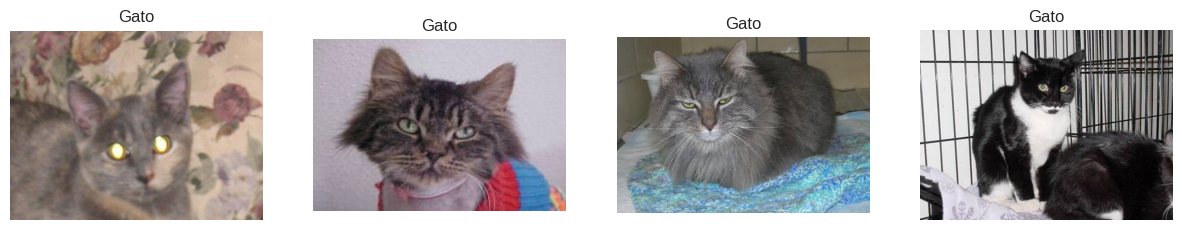

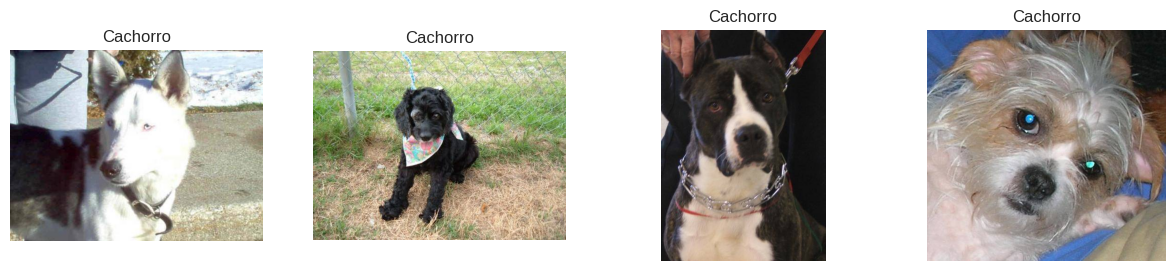

In [ ]:
def show_images_with_labels(results, class_dir, num_images=6):
    plt.figure(figsize=(15, 3))
    for i, (img_name, result) in enumerate(results[:num_images]):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)


        result_lower = result.lower()
        if 'gato' in result_lower:
            title = 'Gato'
        elif 'cachorro' in result_lower:
            title = 'Cachorro'
        else:
            title = 'Desconhecido'

        plt.title(title)
        plt.axis('off')
    plt.show()


show_images_with_labels(cat_results, class_cat_dir, num_images=4)
show_images_with_labels(dog_results, class_dog_dir, num_images=4)


Como podemos ver, as imagens apresentadas foram **classificadas pelo modelo com sucesso**, mostrando uma boa capacidade de distinguir entre gatos e cachorros.

Dentre os modelos avaliados no PyCaret, a Regressão Logística obteve os melhores resultados, com média de:

- **Accuracy:** 0.9806

- **AUC:** 0.9971

- **Recall:** 0.9762

- **Precision:** 0.9852

- **F1-score:** 0.9804

Essas métricas indicam que o modelo apresenta alta precisão e capacidade de generalização, com baixo risco de overfitting — especialmente considerando que o PyCaret aplica técnicas como validação cruzada e ajuste de hiperparâmetros durante o treinamento.



Agora, vamos salvar o modelo, concluindo esta etapa do projeto!

In [ ]:
save_model(final_lr, 'melhor_modelo_gatos_cachorros')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                                                               fill_value=None,
                                                     

## **Obrigada!**

Obrigada por acompanhar! Todo o processo de construir esse modelo e aprender as técnicas envolvidas foi super enriquecedor pra mim. Aprendi muita coisa nova que com certeza vai ajudar na minha carreira profissional.

[![Gmail](https://img.shields.io/badge/Gmail-D14836?style=for-the-badge&logo=gmail&logoColor=white)](mailto:joanatrindade58@gmail.com)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/joanatrindade-)

    
Made with ❤️ by Joana Trindade.

## **Referências**



[1] [TensorFlow / Keras](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)  

[2] [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

[3] [PyCaret](https://pycaret.org/classification/)

[4] [matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)  

[5] [tqdm](https://tqdm.github.io/)  

[6] [pandas](https://pandas.pydata.org/docs/)  

[7] [numpy](https://numpy.org/doc/)  

[8] [warnings (Python standard library)](https://docs.python.org/3/library/warnings.html)  

[9] [base64 (Python standard library)](https://docs.python.org/3/library/base64.html)  

[10] [random (Python standard library)](https://docs.python.org/3/library/random.html)  

[11] [os (Python standard library)](https://docs.python.org/3/library/os.html)  